In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, mean_absolute_error,\
    accuracy_score, f1_score, log_loss, classification_report, roc_curve, auc,\
    roc_auc_score, silhouette_samples, silhouette_score, calinski_harabasz_score


RAND = 10

In [2]:
def calculate_optimal_distance(list_clusters, list_score):
    """
    Поиск наибольшего расстояния для метода локтя
    """
    x1, y1 = list_clusters[0], list_score[0]
    x2, y2 = list_clusters[-1], list_score[-1]
    A, B, C = y1 - y2, x2 - x1, x1 * y2 - x2 * y1

    max_dist = -np.inf
    max_x = -np.inf
    for num, i in enumerate(list_score[1:-1]):
        x_0, y_0 = list_clusters[1:-1][num], list_score[1:-1][num]
        dist = abs(A * x_0 + B * y_0 + C) / np.sqrt(A**2 + B**2)

        if dist > max_dist:
            max_dist = dist
            max_x = x_0
        else:
            continue
    return max_dist, max_x


def elbow_picture(labels_std: list,
                  labels_min: list,
                  labels_max: list,
                  labels_median: list,
                  type_optimal: list,
                  min_size: int,
                  max_size: int):
    """
    Метод локтя

    Функция для вывода графика зависимостей стандартной ошибки, 
    минимального и максимального числа объектов от кол-ва кластеров
    """

    _, opt_cluster = calculate_optimal_distance(
        range(min_size, max_size + 1), type_optimal)

    plt.figure(figsize=(8, 6))
    plt.plot(range(min_size, max_size + 1), labels_std,
             marker='s', color='green', label='std')
    plt.plot(range(min_size, max_size + 1), labels_min,
             marker='s', color='grey', linestyle='dashed', label='min')
    plt.plot(range(min_size, max_size + 1), labels_median,
             marker='o', color='skyblue', linestyle='dashed', label='median')
    plt.plot(range(min_size, max_size + 1), labels_max,
             marker='o', color='grey',  linestyle='dashed', label='max')
    plt.xlabel('Кластер')
    plt.ylabel('Станд.ошибка / Мин.кластер / Median / Макс.кластер')
    plt.axvline(x=opt_cluster, color='black',
                label=f'optimal clust= {opt_cluster}', linestyle='dashed')
    plt.legend()
    plt.show();


def silhouette_plot(data: pd.DataFrame, labels: pd.Series, metrics='euclidean', ax=None):
    """
    Функция вывода графика силуэтного скора
    """
    if ax is None:
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(7, 5)
        
    silhouette_vals = silhouette_samples(data, labels, metric=metrics)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals,
                 edgecolor='none', height=1)
        ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Получение средней оценки силуэтного скора и построение графика
    avg_score = np.mean(silhouette_vals)
    ax.axvline(avg_score, linestyle='--', linewidth=1, color='red')
    ax.set_xlabel(f'Silhouette  = {round(avg_score,1)}')
    ax.set_ylabel('Метки кластеров')
    ax.set_title('График силуэта для различных кластеров', y=1.02)


def metric_picture(score_list: float, min_size: int, max_size: int,
                   name_metric, optimal: bool = True):
    """
    Функция для вывода графика зависимости силуэтной оценки от кол-ва кластеров
    """
    plt.figure(figsize=(8, 6))
    if optimal:
        _, opt_cluster = calculate_optimal_distance(
            range(min_size, max_size + 1), list_score=score_list)
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.axvline(x=opt_cluster, color='black',
                    label=f'optimal clust= {opt_cluster}', linestyle='dashed')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    else:
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    plt.show()
    

def check_fullness(data, labels):
    """
    Функция для проверки медианной заполненности кластера
    Для бинаризованных данных
    """
    sums = []
    #Пробегаем по кластерам
    for label in np.unique(labels):
        #Находим медианную заполненность кластера
        cluster_quantile = data[labels == label].sum(axis = 0).quantile(.5)
        sums.append(cluster_quantile)
    pd.DataFrame(sums).sort_values(by = [0]).plot(kind = "barh", figsize = (8, 6))
    plt.title('Заполненность кластеров')
    plt.ylabel('clusters')
    plt.show()
    

def plot_size(data: pd.DataFrame, labels: pd.Series):
    """
    Фунция для вывода графика размера кластеров    
    """
    plt.title('Размер кластеров')
    cluster_size = data.assign(cluster=labels).groupby(
        'cluster').count().iloc[:, 0]
    cluster_size.sort_values().plot.barh(figsize=(6, 4), color='C0')
    plt.show()
    
    
def plot_top_features(data, labels, n_clusters):
    """
    ТОП-признаки для бинаризованных данных
    """
    binary_label = data.assign(cluster = labels)
    size_cluster = binary_label.groupby('cluster').count().iloc[:,0]
    data_sum = binary_label.groupby('cluster').sum()
    data_sum_norm = data_sum.T / size_cluster

    fig, ax_lst = plt.subplots(n_clusters, 1, figsize = (6,n_clusters*5))
    plt.subplots_adjust(wspace=0.8, hspace=0.3)
    for i in range(n_clusters):
        ax_lst.reshape(-1)[i].set_title('cluster = ' + str(i));
        data_sum_norm.loc[:,i].sort_values()[-10:].plot.barh(ax=ax_lst.reshape(-1)[i], color='C0');
    plt.show();

# Кластеризация

1) Импортировать из датасеты:

- binary_80015360_10sample - датасет с куками (по интекса) и по id интересам (по столбца)
- taxonomy_aidata - таксономия (справочник, сопоставление id с интересами разного уровня агрегации)
- geonames_with_district - справочник с геоданными, где city - id города, тот же id расположен в файле binary_80015360_10sample в колонке city

- Также зафиксируйте random_state RAND=10

- **Выберите только данные по России** (country == 'RU')

In [3]:
df = pd.read_pickle("binary_80015360_10sample.pkl")
taxonomy = pd.read_csv("taxonomy_aidata_17.07.19.csv")
geonames = pd.read_csv("geonames_with_district.csv")

/tmp/ipykernel_10888/2962647208.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  geonames = pd.read_csv("geonames_with_district.csv")


In [4]:
df = df[df['country']=='RU']

In [5]:
df[:5]

10050002  10050003  10060001  20010001  20010002  \
0                                                                          
f4qRvJ1EaISv6Qurqldb/g         0         0         0         1         0   
5GGkI+5DMk07lsKFdEoIxA         0         0         0         1         0   
lqPOeZBIPCJoGkKPDZVLdw         0         0         0         1         0   
NhE8AtdKqtxOkkqeeFZbRw         0         0         0         1         0   
62Azx5tJhORcXnWmVA3RPg         0         0         0         1         0   

                        20010005  20010007  20010008  20010009  20010010  ...  \
0                                                                         ...   
f4qRvJ1EaISv6Qurqldb/g         0         0         0         0         0  ...   
5GGkI+5DMk07lsKFdEoIxA         0         0         0         0         0  ...   
lqPOeZBIPCJoGkKPDZVLdw         0         0         0         0         0  ...   
NhE8AtdKqtxOkkqeeFZbRw         0         1         0         0         0  ...   
62Azx5tJhORcXnWmVA3RPg         0         0         0         0         0  ...   

                        40010267  40010341  40015215  40015407  50000136  \
0                                                                          
f4qRvJ1EaISv6Qurqldb/g         0         0         0         0         0   
5GGkI+5DMk07lsKFdEoIxA         0         0         0         0         0   
lqPOeZBIPCJoGkKPDZVLdw         0         0         0         0         0   
NhE8AtdKqtxOkkqeeFZbRw         0         0         0         0         0   
62Azx5tJhORcXnWmVA3RPg         0         0         0         0         0   

                        90113024  90113053  90113058  country    city  
0                                                                      
f4qRvJ1EaISv6Qurqldb/g         0         0         0       RU  524901  
5GGkI+5DMk07lsKFdEoIxA         0         0         0       RU       -  
lqPOeZBIPCJoGkKPDZVLdw         0         0         0       RU       -  
NhE8AtdKqtxOkkqeeFZbRw         0         0         0       RU       -  
62Azx5tJhORcXnWmVA3RPg         0         0         0       RU  546230  

[5 rows x 1509 columns]

In [6]:
taxonomy[:5]

id level_0         level_1            level_2               level_3  \
0  40011192  Aidata  Food and drink  Nutritional foods             Beverages   
1  40010064  Aidata       Transport        Auto owners  Auto products buyers   
2  40010317  Aidata  Food and drink  Nutritional foods             Beverages   
3  40010792  Aidata  Food and drink  Nutritional foods             Beverages   
4  40010403  Aidata  Food and drink  Nutritional foods             Beverages   

                      level_4                  level_5   segment_name  
0     Non-alcoholic beverages              Coffee fans   Coffeemakers  
1  Auto parts and accessories  Wheels and tires buyers    Bridgestone  
2     Non-alcoholic beverages                        -  Energy Drinks  
3     Non-alcoholic beverages                        -       Tea fans  
4     Non-alcoholic beverages                        -    Coffee fans

In [7]:
geonames[:5]

city        name        region district  auto_region
0  451747  Zyabrikovo  Tver’ Oblast      CFD  Golden Ring
1  451748    Znamenka  Tver’ Oblast      CFD  Golden Ring
2  451749     Zhukovo  Tver’ Oblast      CFD  Golden Ring
3  451750     Zhitovo  Tver’ Oblast      CFD  Golden Ring
4  451751  Zhitnikovo  Tver’ Oblast      CFD  Golden Ring

2) Посмотрите на каждый из датасетов и выведите их

In [8]:
df.columns

Index(['10050002', '10050003', '10060001', '20010001', '20010002', '20010005',
       '20010007', '20010008', '20010009', '20010010',
       ...
       '40010267', '40010341', '40015215', '40015407', '50000136', '90113024',
       '90113053', '90113058', 'country', 'city'],
      dtype='object', length=1509)

In [9]:
taxonomy.id

0       40011192
1       40010064
2       40010317
3       40010792
4       40010403
          ...   
1756    90110074
1757    90110071
1758    90110065
1759    90110070
1760    90110072
Name: id, Length: 1761, dtype: int64

3) Необходимо как в примере из лекции сопоставить **id интереса** из с названием **segment_name** (колонка) в taxonomy, выбираем только **Aidata level_0**!

- Мы должны получить не просто id, а название сегмента

- Будьте аккуратны, так как последний столбец в датасете с куками - это город!
- В конечном итоге у вас должен получиться датасет с сопосталенными названиями сегментов, а последние две колонки - это страна и город

In [10]:
taxonomy = taxonomy[taxonomy['level_0']=='Aidata']

df_id = df[[x for x in df.columns[:-2] if int(x) in list(taxonomy.id)]]

In [11]:
df = pd.concat([df_id, df[df.columns[-2:]]], axis=1)
df[:5]

10050002  10050003  10060001  20010001  20010002  \
0                                                                          
f4qRvJ1EaISv6Qurqldb/g         0         0         0         1         0   
5GGkI+5DMk07lsKFdEoIxA         0         0         0         1         0   
lqPOeZBIPCJoGkKPDZVLdw         0         0         0         1         0   
NhE8AtdKqtxOkkqeeFZbRw         0         0         0         1         0   
62Azx5tJhORcXnWmVA3RPg         0         0         0         1         0   

                        20010005  20010007  20010008  20010009  20010010  ...  \
0                                                                         ...   
f4qRvJ1EaISv6Qurqldb/g         0         0         0         0         0  ...   
5GGkI+5DMk07lsKFdEoIxA         0         0         0         0         0  ...   
lqPOeZBIPCJoGkKPDZVLdw         0         0         0         0         0  ...   
NhE8AtdKqtxOkkqeeFZbRw         0         1         0         0         0  ...   
62Azx5tJhORcXnWmVA3RPg         0         0         0         0         0  ...   

                        40010267  40010341  40015215  40015407  50000136  \
0                                                                          
f4qRvJ1EaISv6Qurqldb/g         0         0         0         0         0   
5GGkI+5DMk07lsKFdEoIxA         0         0         0         0         0   
lqPOeZBIPCJoGkKPDZVLdw         0         0         0         0         0   
NhE8AtdKqtxOkkqeeFZbRw         0         0         0         0         0   
62Azx5tJhORcXnWmVA3RPg         0         0         0         0         0   

                        90113024  90113053  90113058  country    city  
0                                                                      
f4qRvJ1EaISv6Qurqldb/g         0         0         0       RU  524901  
5GGkI+5DMk07lsKFdEoIxA         0         0         0       RU       -  
lqPOeZBIPCJoGkKPDZVLdw         0         0         0       RU       -  
NhE8AtdKqtxOkkqeeFZbRw         0         0         0       RU       -  
62Azx5tJhORcXnWmVA3RPg         0         0         0       RU  546230  

[5 rows x 878 columns]

In [12]:
cols = [taxonomy[taxonomy.id == int(x)].segment_name.values[0] for x in df.columns[:-2]]

cols = cols + ['country', 'city']
df.columns = cols

In [13]:
df[:5]

Graduate school  Colleges & university  Singles  \
0                                                                         
f4qRvJ1EaISv6Qurqldb/g                0                      0        0   
5GGkI+5DMk07lsKFdEoIxA                0                      0        0   
lqPOeZBIPCJoGkKPDZVLdw                0                      0        0   
NhE8AtdKqtxOkkqeeFZbRw                0                      0        0   
62Azx5tJhORcXnWmVA3RPg                0                      0        0   

                        Auto buyers and fans  Gaming  Diet and fitness  \
0                                                                        
f4qRvJ1EaISv6Qurqldb/g                     1       0                 0   
5GGkI+5DMk07lsKFdEoIxA                     1       0                 0   
lqPOeZBIPCJoGkKPDZVLdw                     1       0                 0   
NhE8AtdKqtxOkkqeeFZbRw                     1       0                 0   
62Azx5tJhORcXnWmVA3RPg                     1       0                 0   

                        Events  Small business owners  Green living  \
0                                                                     
f4qRvJ1EaISv6Qurqldb/g       0                      0             0   
5GGkI+5DMk07lsKFdEoIxA       0                      0             0   
lqPOeZBIPCJoGkKPDZVLdw       0                      0             0   
NhE8AtdKqtxOkkqeeFZbRw       1                      0             0   
62Azx5tJhORcXnWmVA3RPg       0                      0             0   

                        Guys and gear  ...  Painting and papering  \
0                                      ...                          
f4qRvJ1EaISv6Qurqldb/g              0  ...                      0   
5GGkI+5DMk07lsKFdEoIxA              0  ...                      0   
lqPOeZBIPCJoGkKPDZVLdw              0  ...                      0   
NhE8AtdKqtxOkkqeeFZbRw              0  ...                      0   
62Azx5tJhORcXnWmVA3RPg              0  ...                      0   

                        Media and communication  Kamchatka travel  London  \
0                                                                           
f4qRvJ1EaISv6Qurqldb/g                        0                 0       0   
5GGkI+5DMk07lsKFdEoIxA                        0                 0       0   
lqPOeZBIPCJoGkKPDZVLdw                        0                 0       0   
NhE8AtdKqtxOkkqeeFZbRw                        0                 0       0   
62Azx5tJhORcXnWmVA3RPg                        0                 0       0   

                        Vauxhall  Desktops  Projectors  \
0                                                        
f4qRvJ1EaISv6Qurqldb/g         0         0           0   
5GGkI+5DMk07lsKFdEoIxA         0         0           0   
lqPOeZBIPCJoGkKPDZVLdw         0         0           0   
NhE8AtdKqtxOkkqeeFZbRw         0         0           0   
62Azx5tJhORcXnWmVA3RPg         0         0           0   

                        Small kitchen appliances buyers  country    city  
0                                                                         
f4qRvJ1EaISv6Qurqldb/g                                0       RU  524901  
5GGkI+5DMk07lsKFdEoIxA                                0       RU       -  
lqPOeZBIPCJoGkKPDZVLdw                                0       RU       -  
NhE8AtdKqtxOkkqeeFZbRw                                0       RU       -  
62Azx5tJhORcXnWmVA3RPg                                0       RU  546230  

[5 rows x 878 columns]

4) Наподобие как с сегментами, нужно каждому id города в получившемся датасете (после переименования столбцов при помощи taxonomy) сопоставить название региона из файла **geo** (колонка auto_region).

- Для этого создайте новый датасет, где соедините получившийся **датасет на предыдущем шаге** и **geo** по признаку **city** (LEFT JOIN), вы получите дополнительную колонку **auto_region**

- Будьте аккуратны, так как тип данных признака city в датасете из задания 3 - str, а тип данных в geo.city - int (нужно преобразовать тип данных int признака city в geo файле в тип str)

- Удалите лишние признаки **city, country** в получившемся новом датасете

In [14]:
geonames.city = geonames.city.astype('str')

In [15]:
df_merged = df.merge(geonames[['city', 'auto_region']], how='left', on='city')
df_merged[:5]

Graduate school  Colleges & university  Singles  Auto buyers and fans  \
0                0                      0        0                     1   
1                0                      0        0                     1   
2                0                      0        0                     1   
3                0                      0        0                     1   
4                0                      0        0                     1   

   Gaming  Diet and fitness  Events  Small business owners  Green living  \
0       0                 0       0                      0             0   
1       0                 0       0                      0             0   
2       0                 0       0                      0             0   
3       0                 0       1                      0             0   
4       0                 0       0                      0             0   

   Guys and gear  ...  Media and communication  Kamchatka travel  London  \
0              0  ...                        0                 0       0   
1              0  ...                        0                 0       0   
2              0  ...                        0                 0       0   
3              0  ...                        0                 0       0   
4              0  ...                        0                 0       0   

   Vauxhall  Desktops  Projectors  Small kitchen appliances buyers  country  \
0         0         0           0                                0       RU   
1         0         0           0                                0       RU   
2         0         0           0                                0       RU   
3         0         0           0                                0       RU   
4         0         0           0                                0       RU   

     city  auto_region  
0  524901       Moscou  
1       -            -  
2       -            -  
3       -            -  
4  546230       Moscou  

[5 rows x 879 columns]

In [16]:
df_merged = df_merged.drop(['city', 'country'], axis=1)
df_merged[:5]

Graduate school  Colleges & university  Singles  Auto buyers and fans  \
0                0                      0        0                     1   
1                0                      0        0                     1   
2                0                      0        0                     1   
3                0                      0        0                     1   
4                0                      0        0                     1   

   Gaming  Diet and fitness  Events  Small business owners  Green living  \
0       0                 0       0                      0             0   
1       0                 0       0                      0             0   
2       0                 0       0                      0             0   
3       0                 0       1                      0             0   
4       0                 0       0                      0             0   

   Guys and gear  ...  Italian restaurants  Painting and papering  \
0              0  ...                    0                      0   
1              0  ...                    0                      0   
2              0  ...                    0                      0   
3              0  ...                    0                      0   
4              0  ...                    0                      0   

   Media and communication  Kamchatka travel  London  Vauxhall  Desktops  \
0                        0                 0       0         0         0   
1                        0                 0       0         0         0   
2                        0                 0       0         0         0   
3                        0                 0       0         0         0   
4                        0                 0       0         0         0   

   Projectors  Small kitchen appliances buyers  auto_region  
0           0                                0       Moscou  
1           0                                0            -  
2           0                                0            -  
3           0                                0            -  
4           0                                0       Moscou  

[5 rows x 877 columns]

In [17]:
df_merged[["Income 0-20 inferred", "Income 60-80 inferred"]]

Income 0-20 inferred  Income 60-80 inferred
0                         0                      0
1                         1                      1
2                         0                      0
3                         0                      1
4                         0                      1
...                     ...                    ...
56242                     1                      1
56243                     1                      1
56244                     0                      0
56245                     0                      0
56246                     0                      1

[56247 rows x 2 columns]

5) 

- Бинаризуйте новый признак auto_region (get_dummies), остальные признаки оставьте в том же виде, данные запишите в новый датасет
- Удалите признак **'auto_region_-'**
- Ничего страшного, если пропали индексы кук, для обучения они нам не нужны

In [18]:
df_label = pd.get_dummies(df_merged, columns=['auto_region'])
df_label[:5]

Graduate school  Colleges & university  Singles  Auto buyers and fans  \
0                0                      0        0                     1   
1                0                      0        0                     1   
2                0                      0        0                     1   
3                0                      0        0                     1   
4                0                      0        0                     1   

   Gaming  Diet and fitness  Events  Small business owners  Green living  \
0       0                 0       0                      0             0   
1       0                 0       0                      0             0   
2       0                 0       0                      0             0   
3       0                 0       1                      0             0   
4       0                 0       0                      0             0   

   Guys and gear  ...  auto_region_Golden Ring  auto_region_Moscou  \
0              0  ...                        0                   1   
1              0  ...                        0                   0   
2              0  ...                        0                   0   
3              0  ...                        0                   0   
4              0  ...                        0                   1   

   auto_region_Nord  auto_region_Oural  auto_region_Siberie  auto_region_Sud  \
0                 0                  0                    0                0   
1                 0                  0                    0                0   
2                 0                  0                    0                0   
3                 0                  0                    0                0   
4                 0                  0                    0                0   

   auto_region_Sud-Est  auto_region_Sud-Ouest  auto_region_Sud-Oural  \
0                    0                      0                      0   
1                    0                      0                      0   
2                    0                      0                      0   
3                    0                      0                      0   
4                    0                      0                      0   

   auto_region_Volga  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 889 columns]

In [19]:
df.shape

(56247, 878)

6) Возьмите пример из лекции, где мы отсекали плохозаполненные куки и сделайте отсечение данных по полувшемуся порогу. Запишите результаты в новый датасет cleaned_dataset. Сэмпл брать не нужно!

Код начинался с:

#Суммируем значения сегментов по кукам 

id_sums = df_label.sum(axis = 1)

In [20]:
id_sums = df_label.sum(axis=1)
counts = np.unique(id_sums, return_counts=True)[1]
std = counts.std()

In [21]:
max_threshold = 0
np.unique(id_sums, return_counts=True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        119, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 133, 134,
        136, 137, 140, 141, 145, 147, 151, 154, 155, 160, 180]),
 array([1095,  715, 8901, 3851, 3736, 2589, 2110, 2604, 2045, 1707, 1336,
        1442, 1207, 1271, 1156, 1117,  997,  907,  915,  894,  825,  785,
         722,  730,  654,  635,  624,  588,  578,  532,  

In [22]:
for count_id, count in enumerate(counts):
    if count > 2*std:
            threshold = np.unique(df_label.sum(
                axis=1), return_counts=True)[0][count_id]
            if threshold > max_threshold:
                max_threshold = threshold

In [23]:
max_threshold

9

In [24]:
cleaned_dataset = df_label[id_sums > max_threshold]
cleaned_dataset.shape

(28601, 889)

Чтобы все алгоритм спектарльной кластеризации считался быстрее, **возьмите сэмпл данных размером 15000** и запишите в переменную **df_sample**. Только для спектральной!

In [25]:
df_sample = cleaned_dataset.sample(15000, axis=0, random_state=RAND)
df_sample[:5]

Graduate school  Colleges & university  Singles  Auto buyers and fans  \
45681                0                      0        0                     1   
47203                0                      0        0                     1   
1937                 0                      0        0                     1   
50617                0                      0        0                     1   
36745                0                      0        0                     1   

       Gaming  Diet and fitness  Events  Small business owners  Green living  \
45681       1                 0       0                      0             0   
47203       0                 0       0                      0             0   
1937        0                 1       0                      1             1   
50617       1                 1       1                      0             0   
36745       0                 0       0                      0             0   

       Guys and gear  ...  auto_region_Golden Ring  auto_region_Moscou  \
45681              0  ...                        0                   0   
47203              0  ...                        0                   1   
1937               0  ...                        0                   0   
50617              0  ...                        0                   1   
36745              0  ...                        0                   0   

       auto_region_Nord  auto_region_Oural  auto_region_Siberie  \
45681                 0                  0                    0   
47203                 0                  0                    0   
1937                  0                  0                    0   
50617                 0                  0                    0   
36745                 0                  0                    0   

       auto_region_Sud  auto_region_Sud-Est  auto_region_Sud-Ouest  \
45681                1                    0                      0   
47203                0                    0                      0   
1937                 1                    0                      0   
50617                0                    0                      0   
36745                1                    0                      0   

       auto_region_Sud-Oural  auto_region_Volga  
45681                      0                  0  
47203                      0                  0  
1937                       0                  0  
50617                      0                  0  
36745                      0                  0  

[5 rows x 889 columns]

## UMAP

7) 

- Примените метод UMAP для датасета cleaned_dataset и для df_sample отдельно, создайте эмбеддинги с параметрами n_components=2 (двумерное пространство), не забывайте про random_state
- Отобразите как в примере из лекций эмбеддинги на двумерном графике

In [26]:
from umap import UMAP

In [27]:
um = UMAP(n_components=2, random_state=RAND)
x_embedding = um.fit_transform(cleaned_dataset)
x_embedding

array([[ 4.974348 ,  5.5131016],
       [ 7.961024 ,  5.328479 ],
       [ 8.809356 ,  7.9433346],
       ...,
       [ 9.454489 ,  6.353888 ],
       [10.737398 ,  5.27296  ],
       [ 7.7281947,  6.4067883]], dtype=float32)

<Axes: >

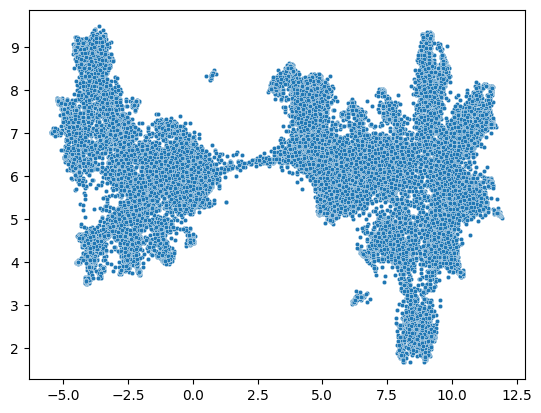

In [28]:
sns.scatterplot(x=x_embedding[:,0], y=x_embedding[:,1], s=10)

<Axes: >

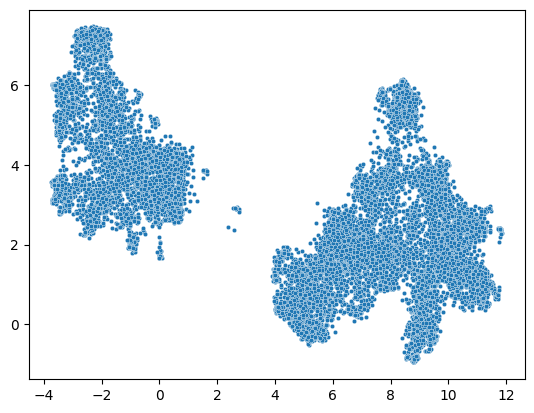

In [29]:
um = UMAP(n_components=2, random_state=RAND)
x_embedding_sample = um.fit_transform(df_sample)
sns.scatterplot(x=x_embedding_sample[:,0], y=x_embedding_sample[:,1], s=10)

## Clustering

### SpectralClustering

8) Выбор кол-ва кластеров на основании спектральной кластеризации

- 1) создайте пустые списки для: 
    - значения стандартной ошибки, min, median и max кол-ва объектов в кластере
    - метрики calinski_harabasz
    - silhouette
- 2) В цикле вам необходимо от 2 до 10 кластеров сделать следующие действия:
    - 2.1) обучить алгоритм спектральной кластеризации на кол-ве кластеров на текущем шаге цикла, использовать именно полученный датасет из задания 6 - **df_sample**, а также affinity='cosine'
    - 2.2) вывести график топ фичей при помощи функции plot_top_features(), подав на вход датасет df_sample, размеченные метки кластеров (пример clf.labels_) а также кол-во кластеров на текущем шаге цикла
    - 2.3) вывести график силуэтного скора при помощи функции silhouette_plot(), подав на вход датасет df_sample, размеченные метки кластеров (пример clf.labels_), а также **косинусную метрику**
    - 2.4) вывести график заполенности при помощи функции check_fullness(), подав на вход датасет df_sample, размеченные метки кластеров (пример clf.labels_)
    - 2.5) вывести график размеров кластеров при помощи функции plot_size(), подав на вход датасет df_sample, размеченные метки кластеров (пример clf.labels_)
    - 2.6) Добавить в списки для calinski_harabasz, silhouette соответствующие значения метрик, для silhouette использовать **косинусную метрику при вычислении значения**
    - 2.7) как в примере из лекций вычислить кол-во уникальных объектов в каждом кластере (_, counts = np.unique(clf.labels_, return_counts=True))
    - 2.8) найти стандартную ошибку, min, median и max кол-во объектов в кластере, используя предыдущий пункт, и записать в соответствующие ранее объявленные списки
- 3) после самого цикла вывести графики:
    - 3.1) зависимостей стандартной ошибки, min, median, max при помощи функции elbow_picture(), подав на вход списки, которые заполняли в цикле на шаге 2.7 
    - 3.2) Изменение метрики calinski_harabasz в зависимости от кол-ва кластеров, используя метод metric_picture
    - 3.3) Изменение метрики silhouette в зависимости от кол-ва кластеров, используя метод metric_picture
    
**Важно** везде используйте датасет из задания 6, даже для подачи в разные метрики

**P.S. считается долго, можно пойти пока попить кофе/чай =)**

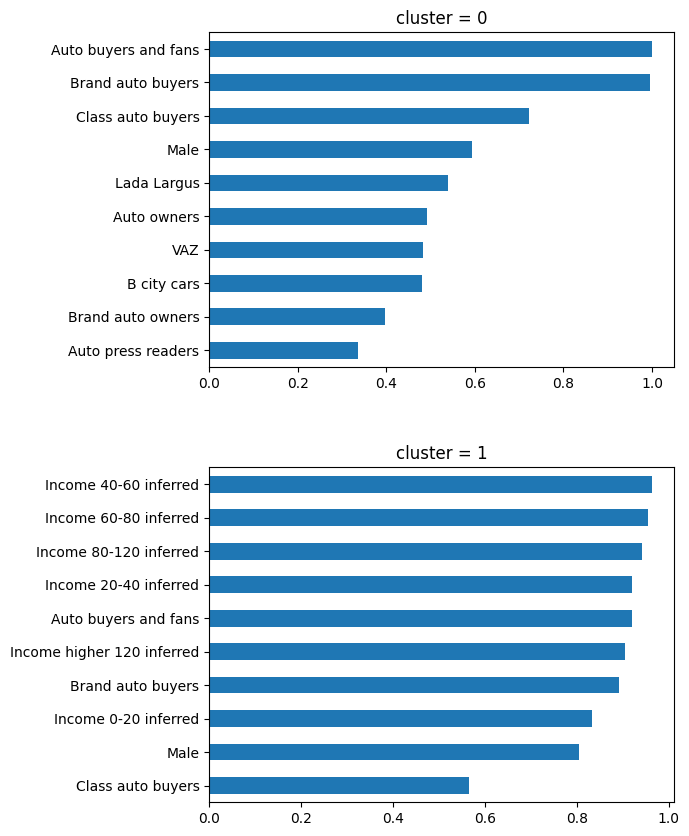

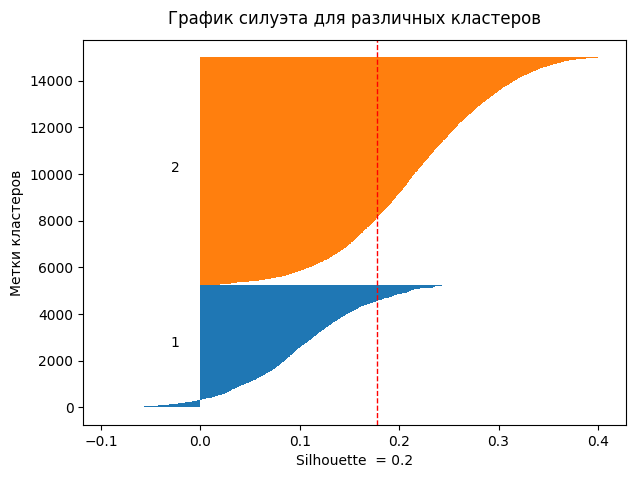

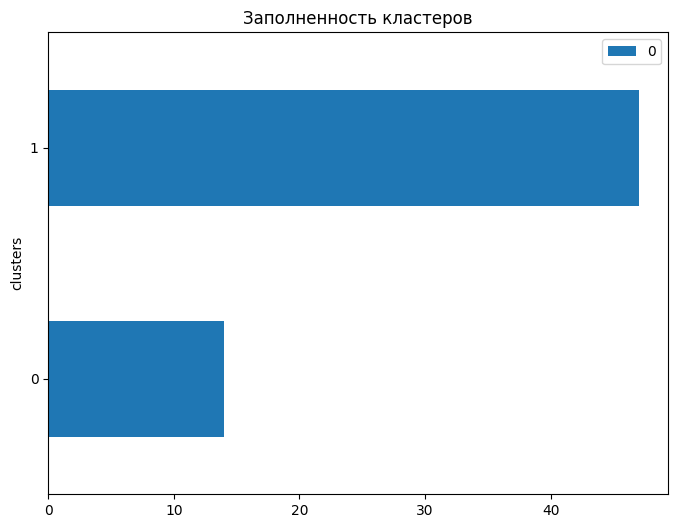

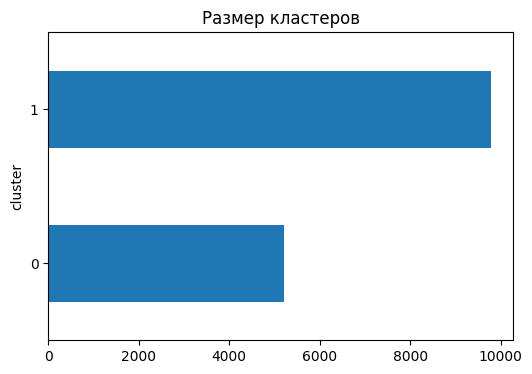

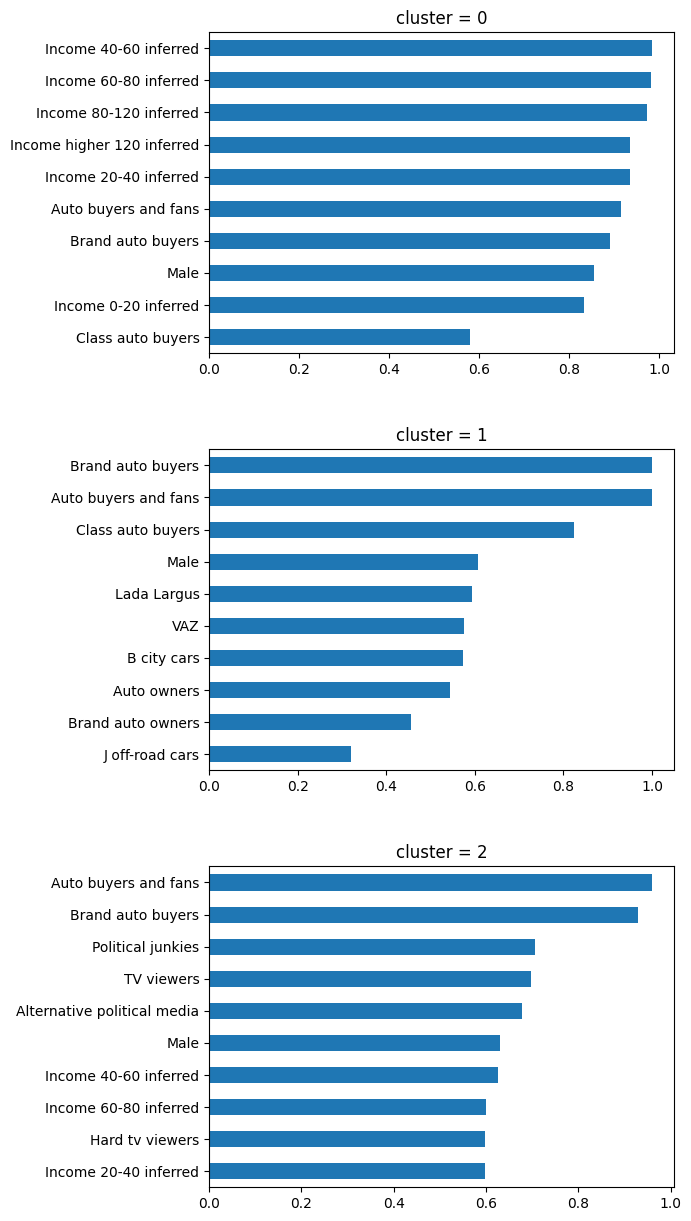

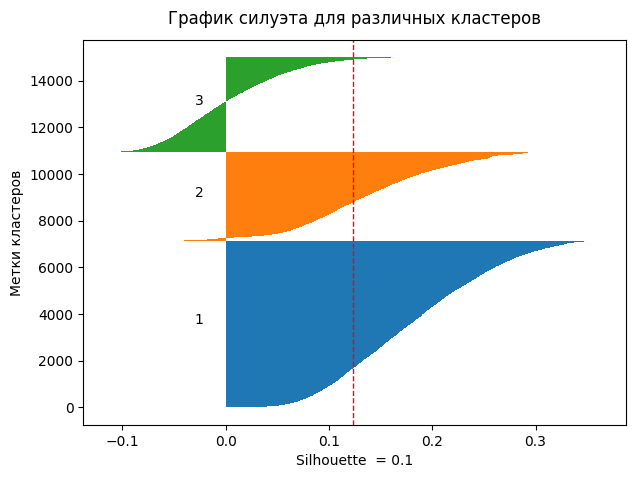

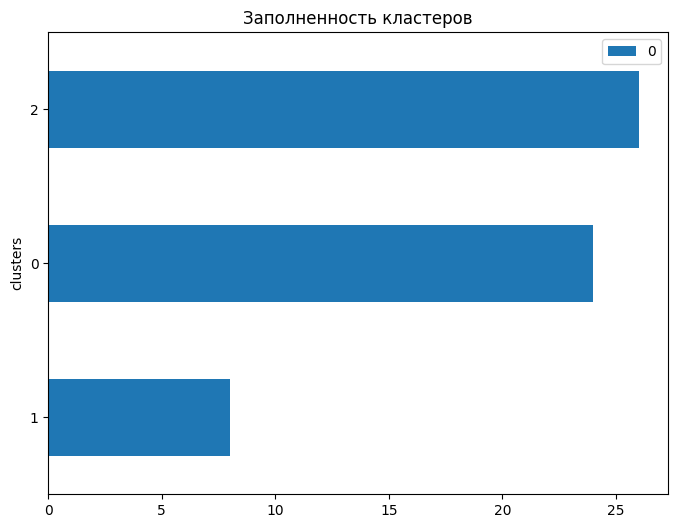

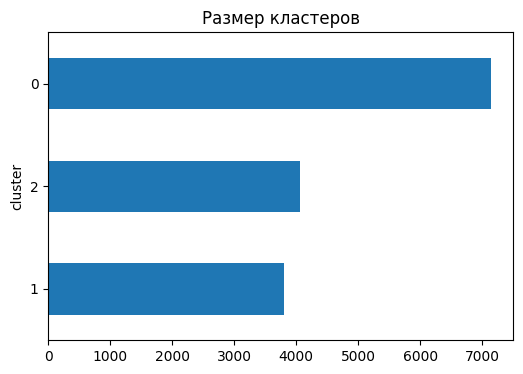

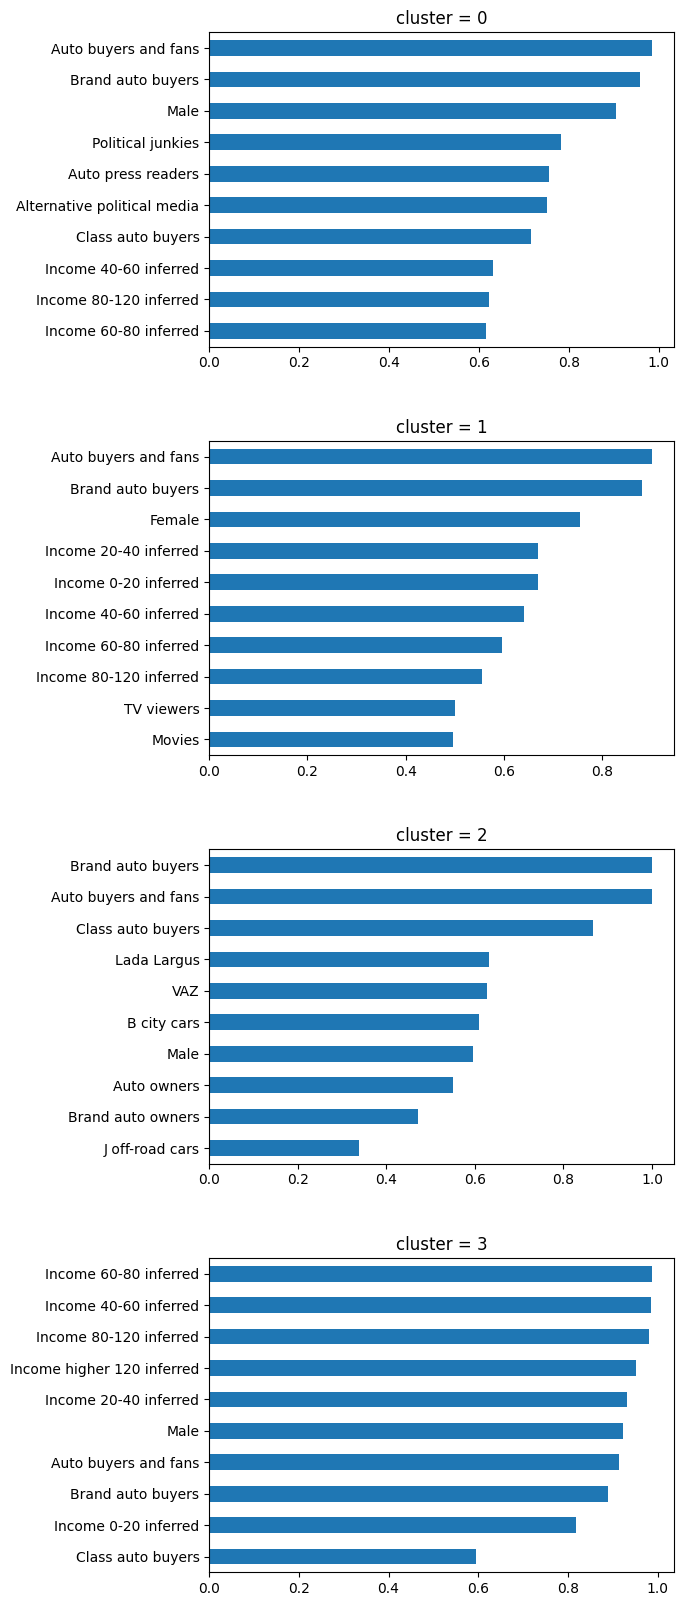

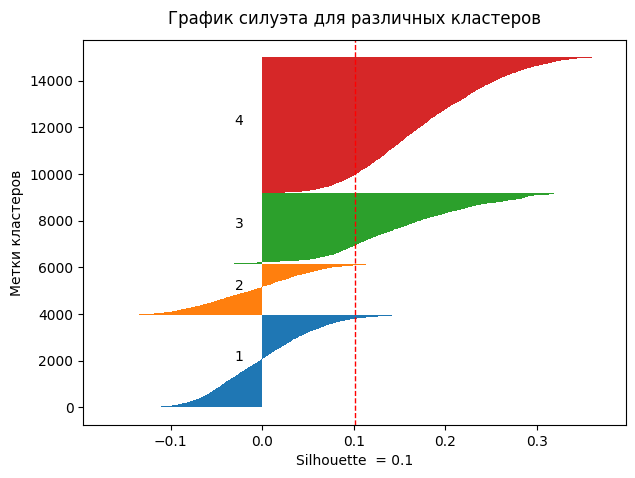

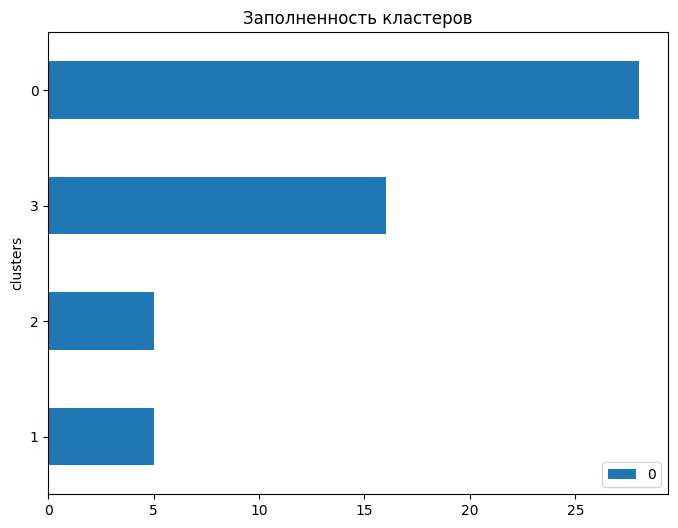

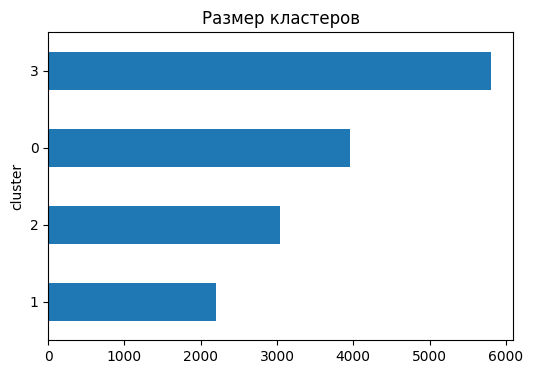

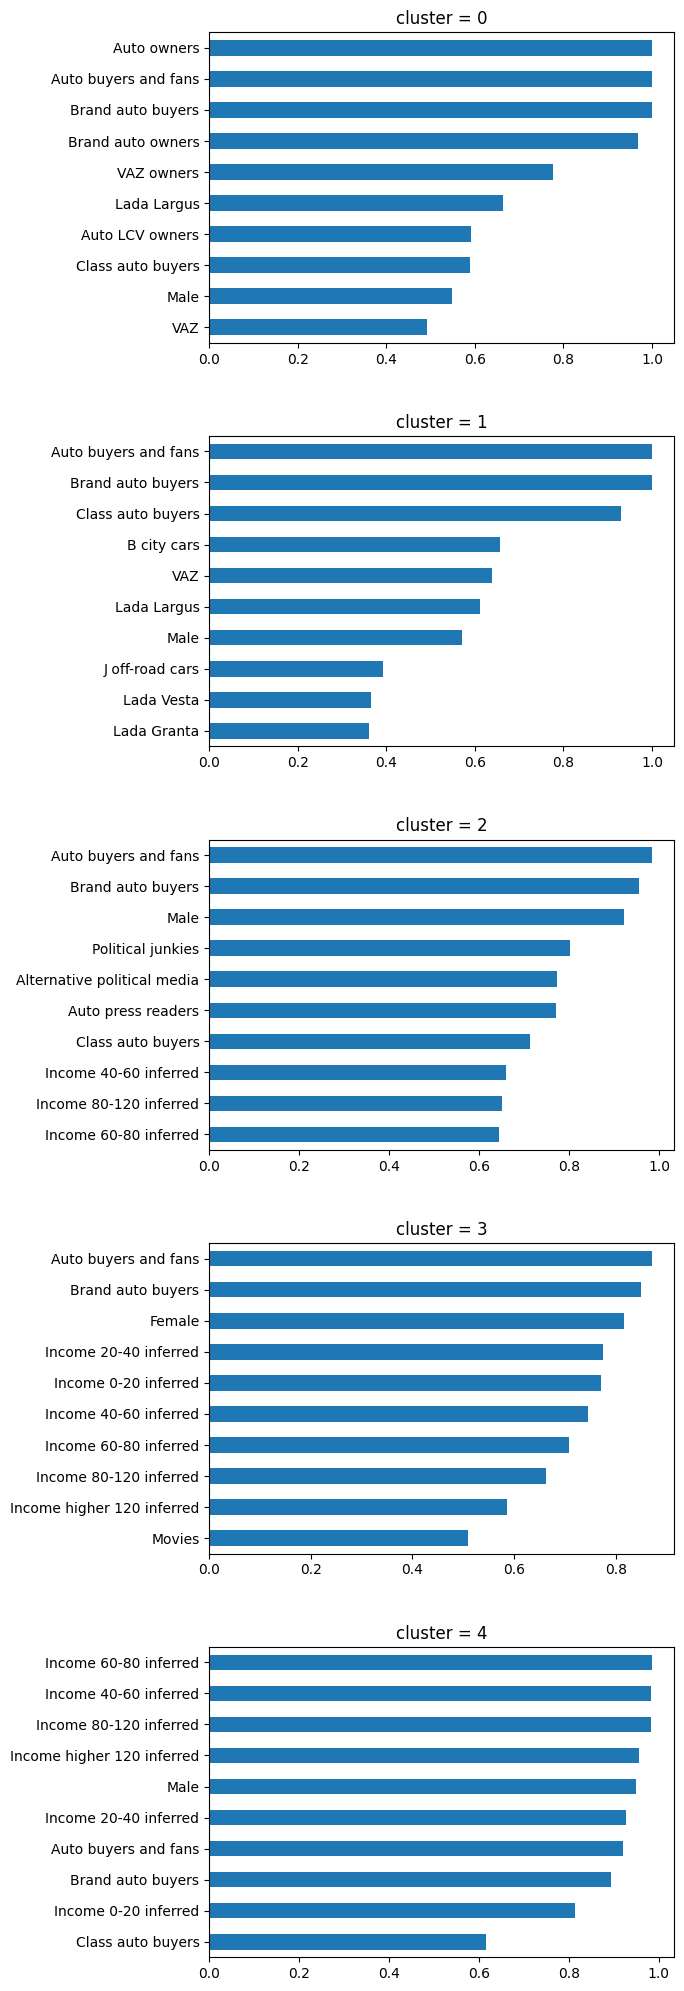

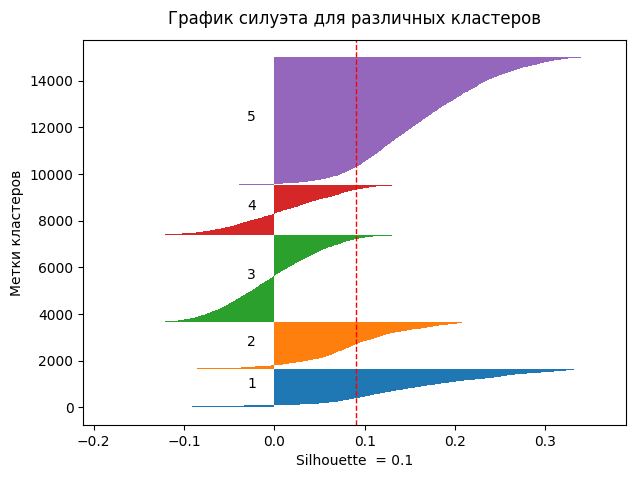

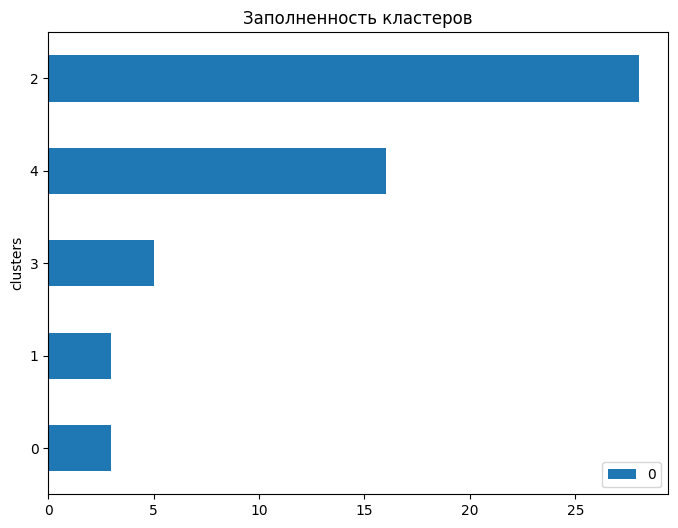

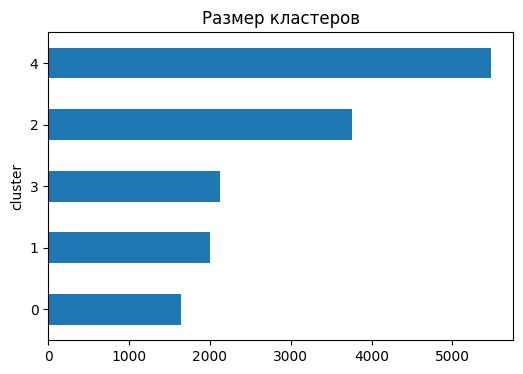

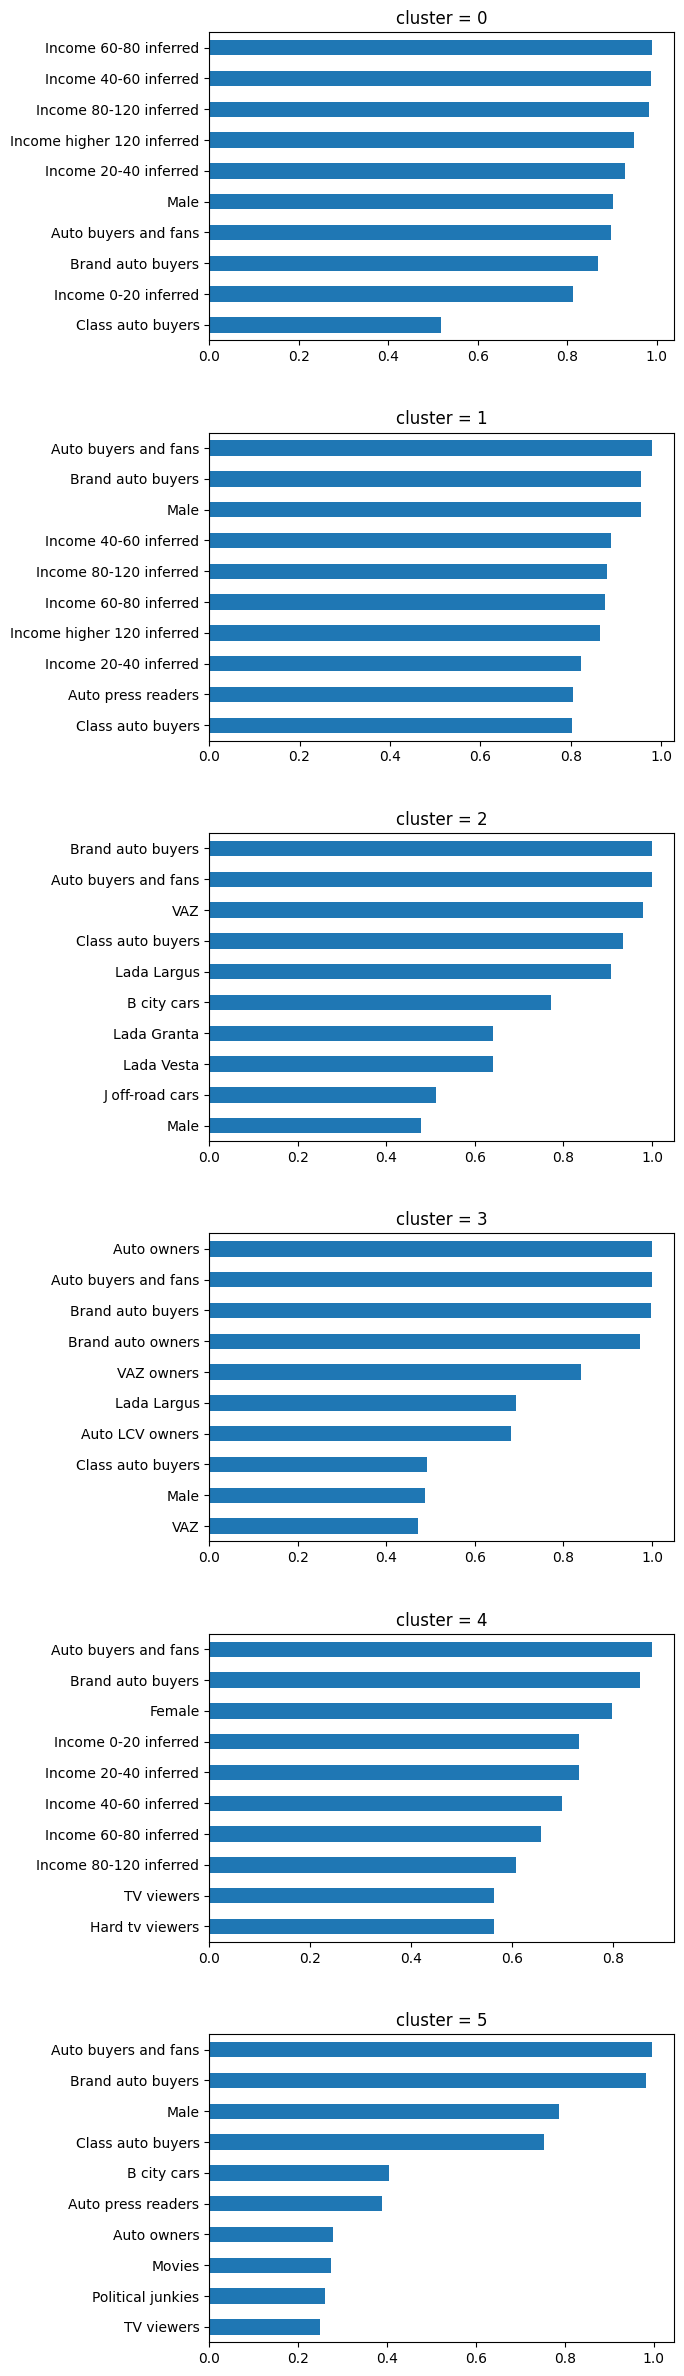

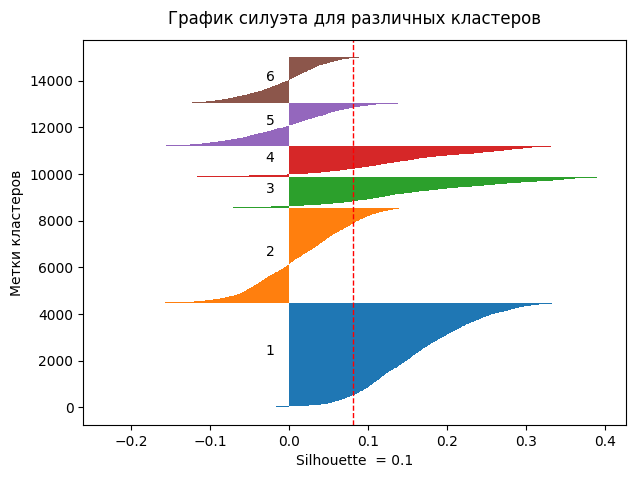

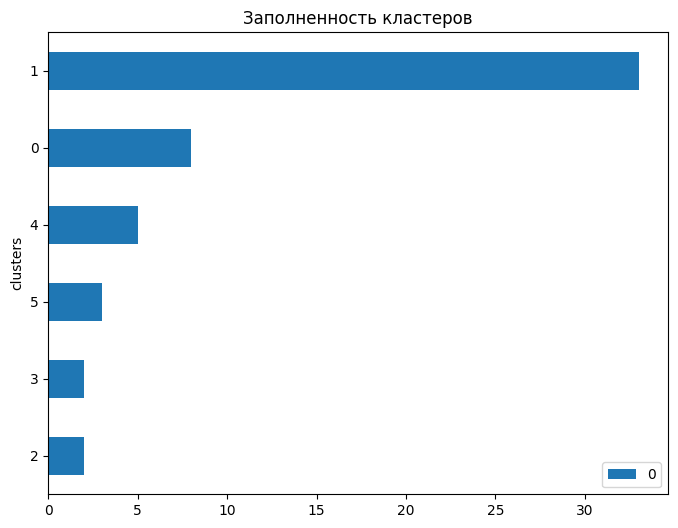

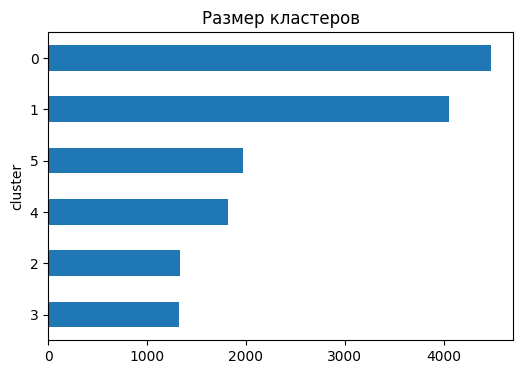

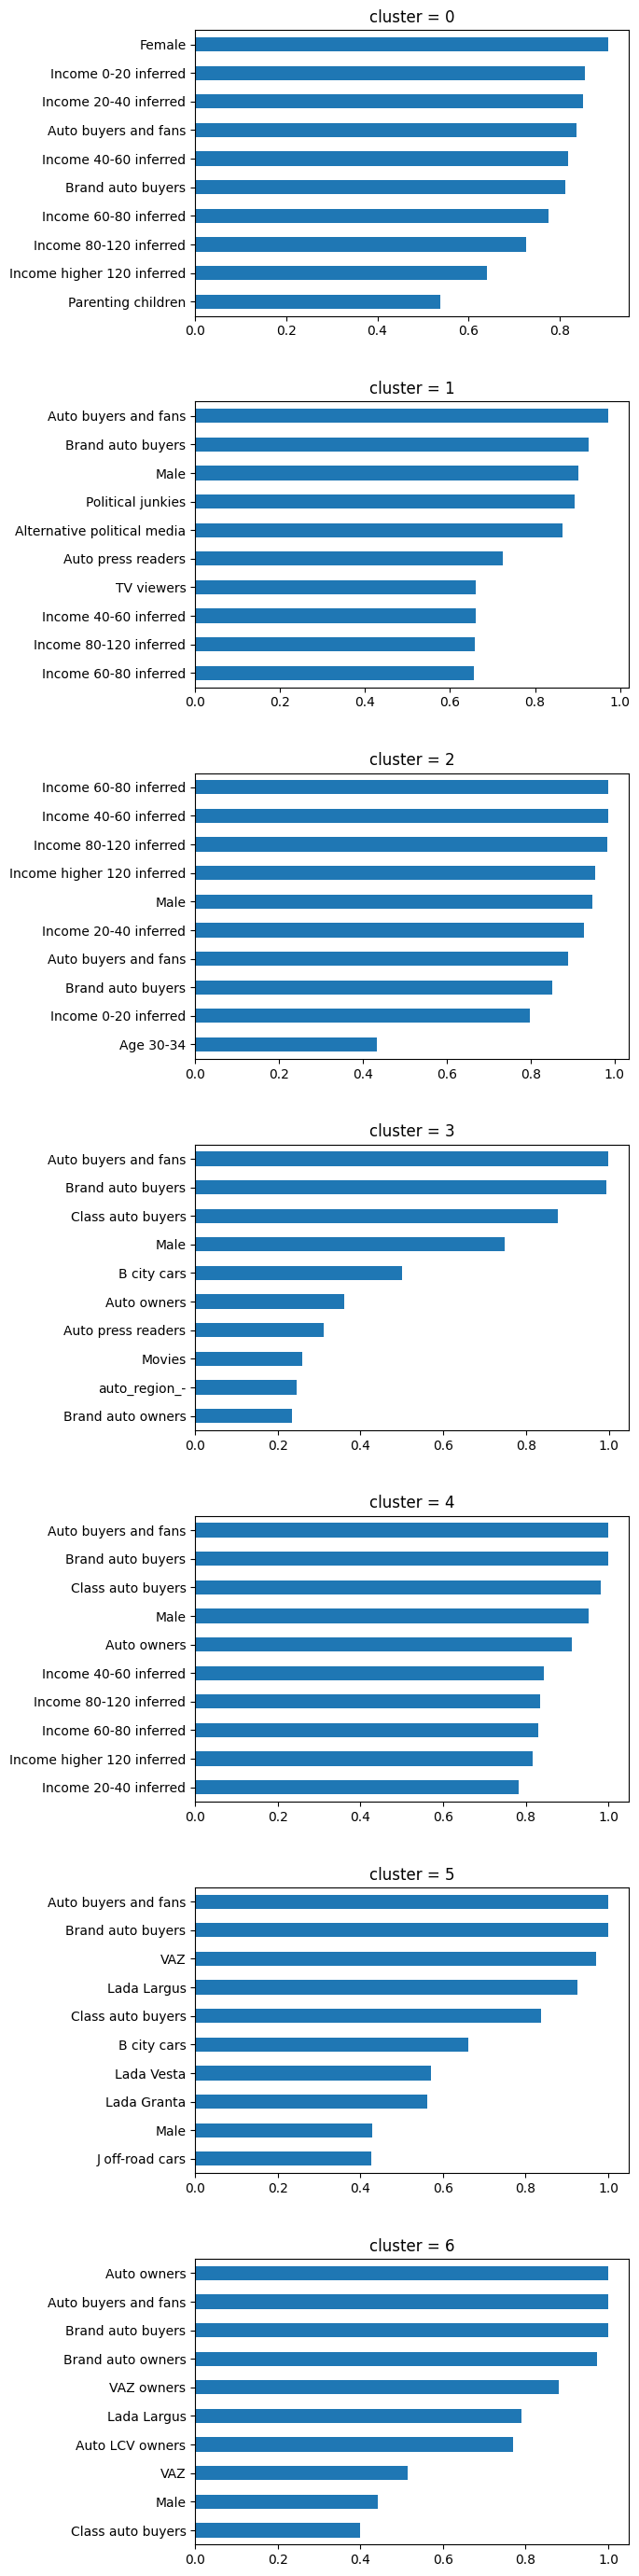

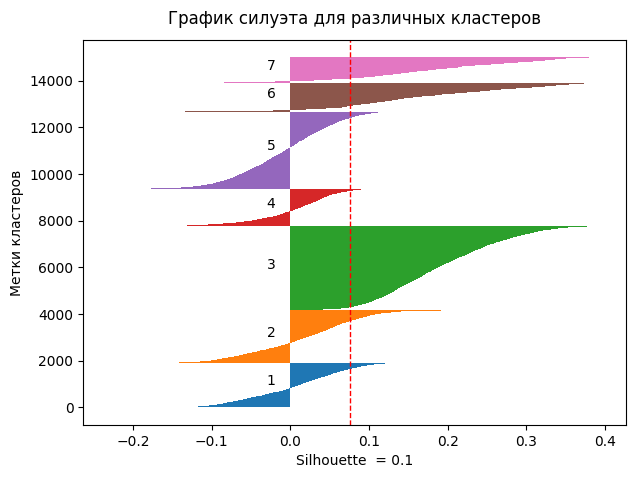

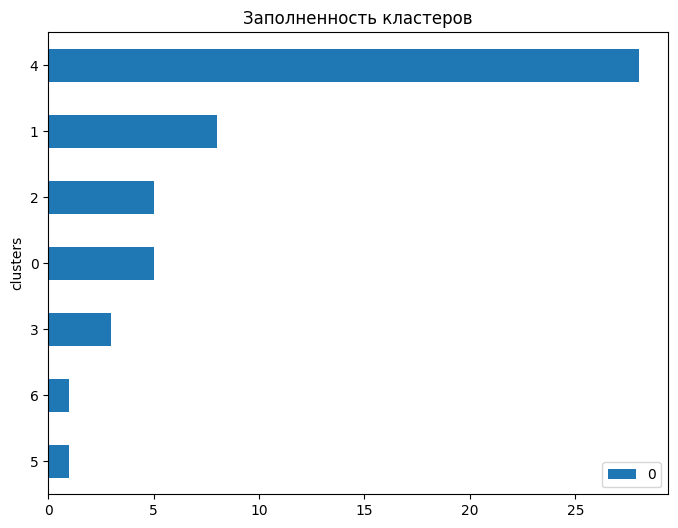

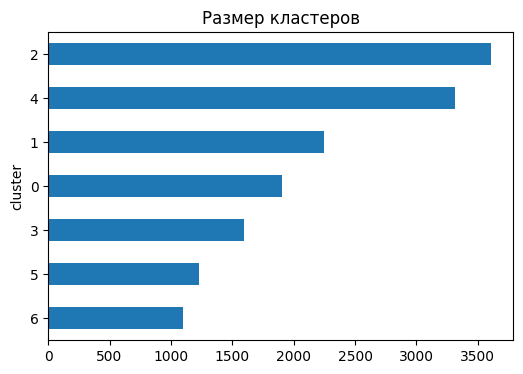

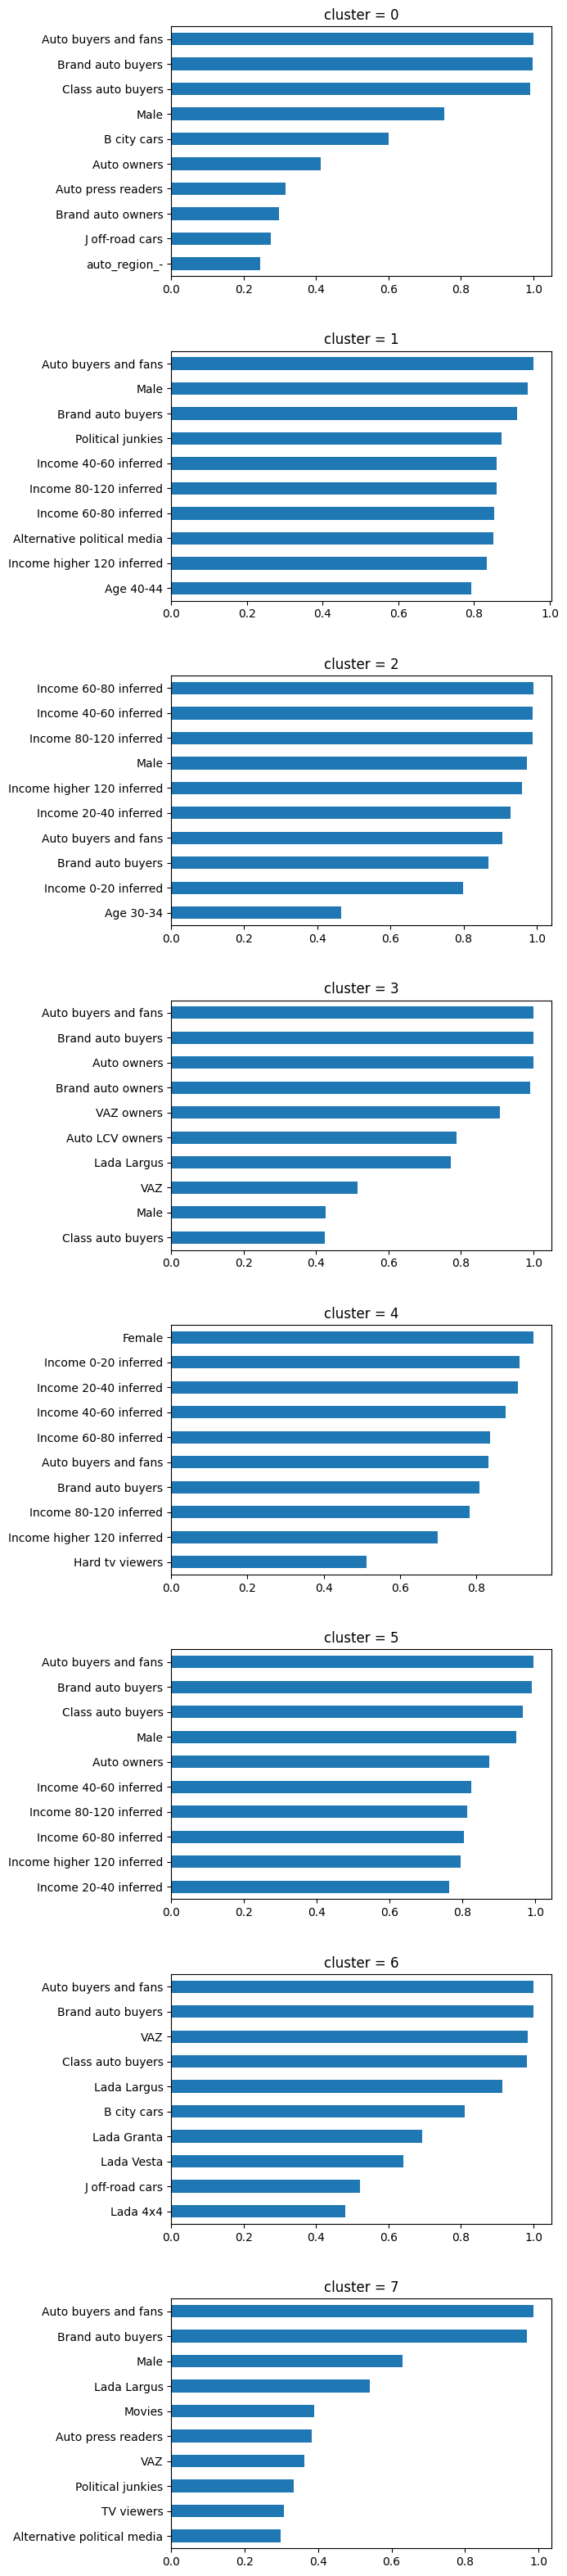

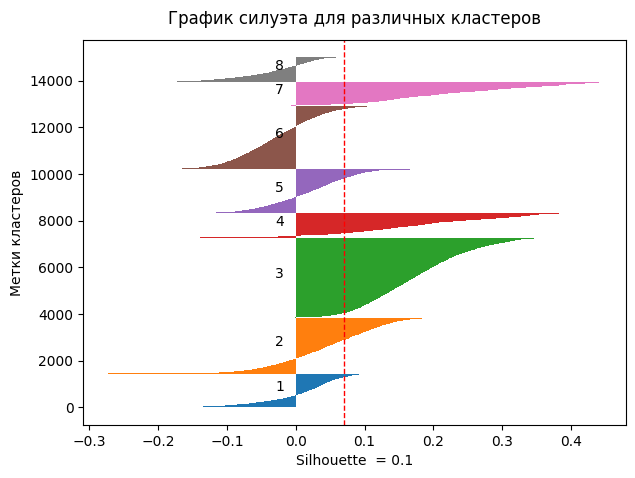

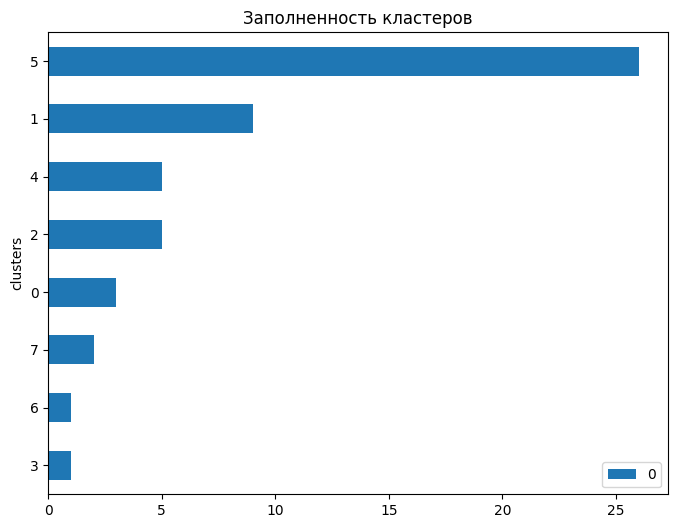

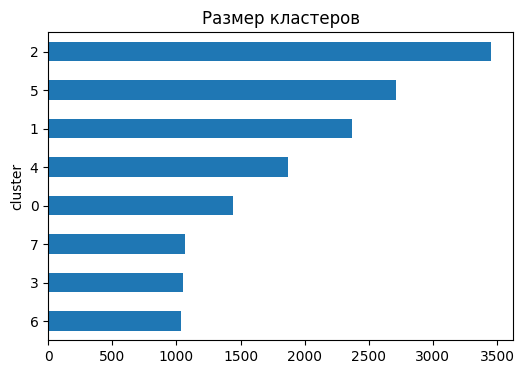

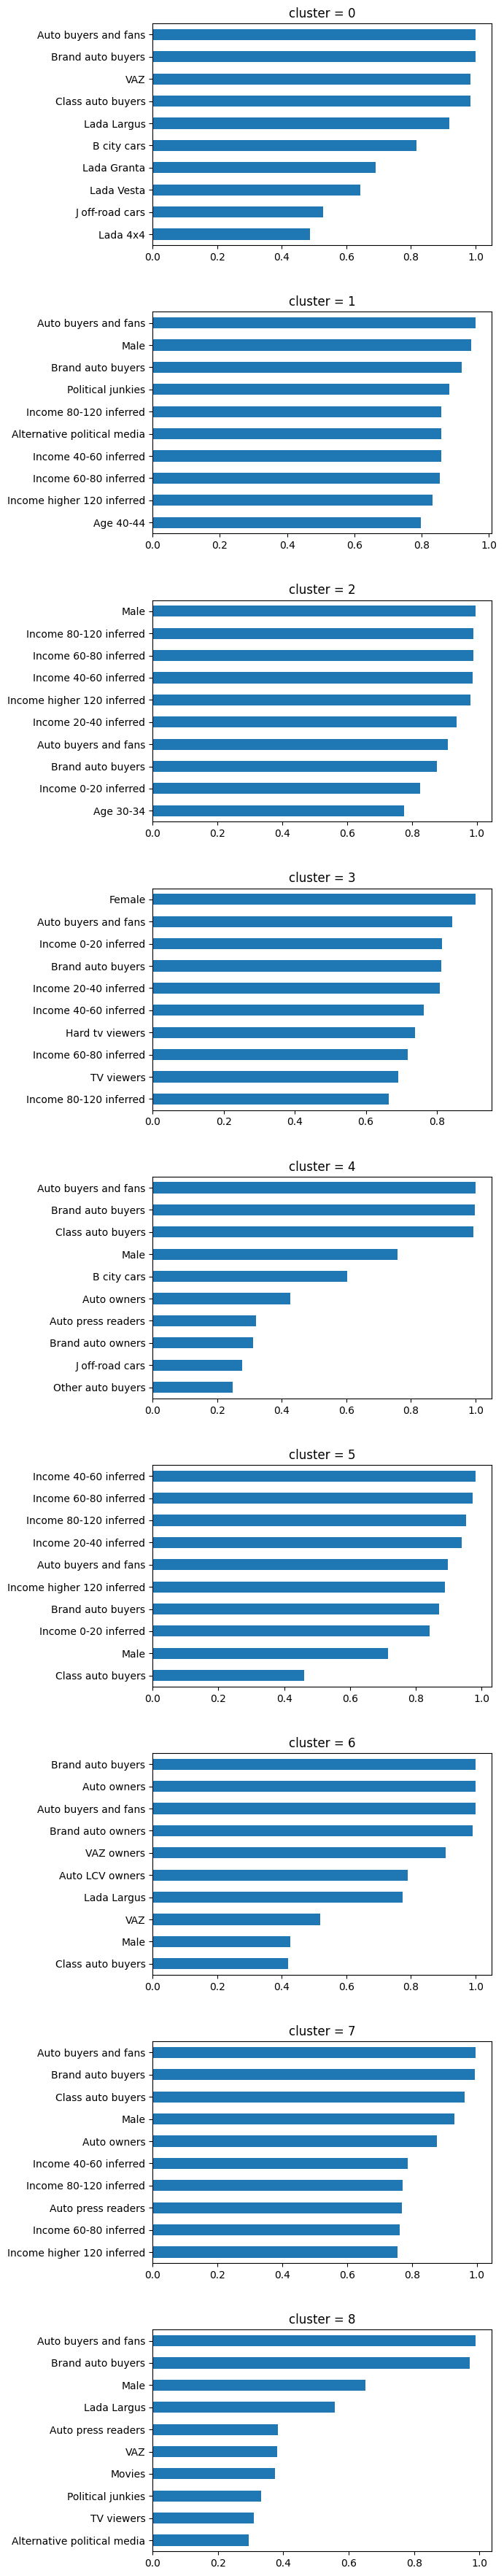

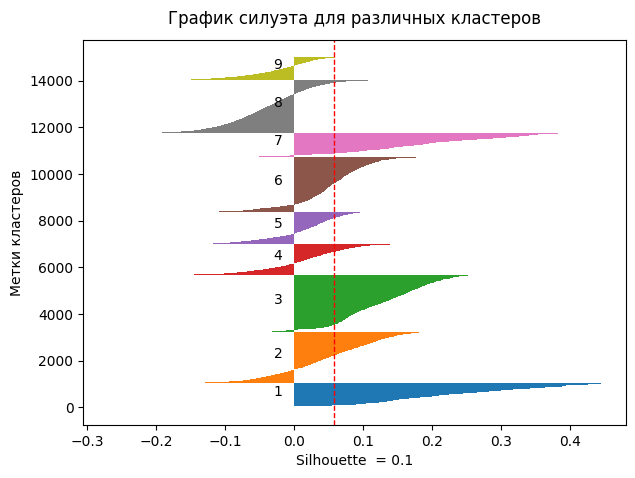

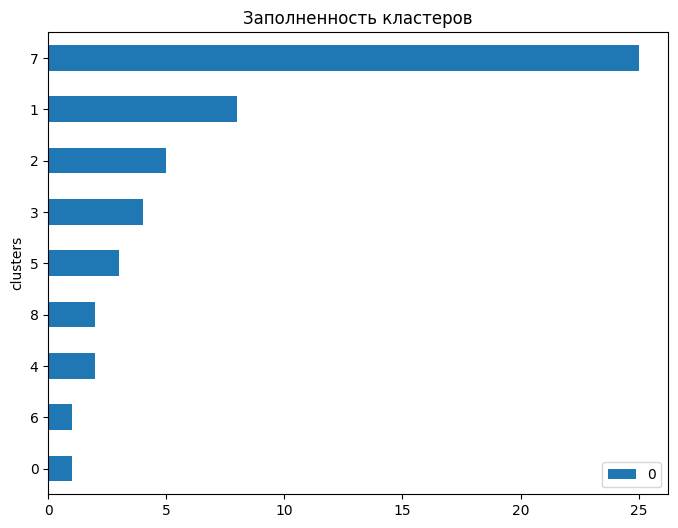

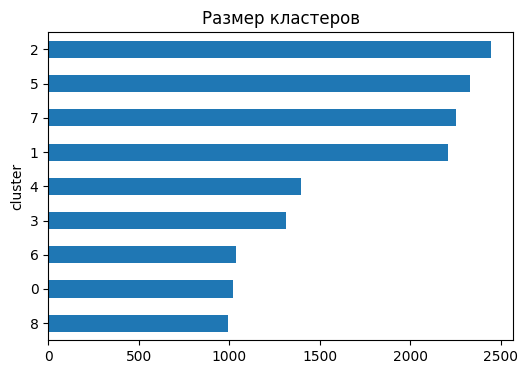

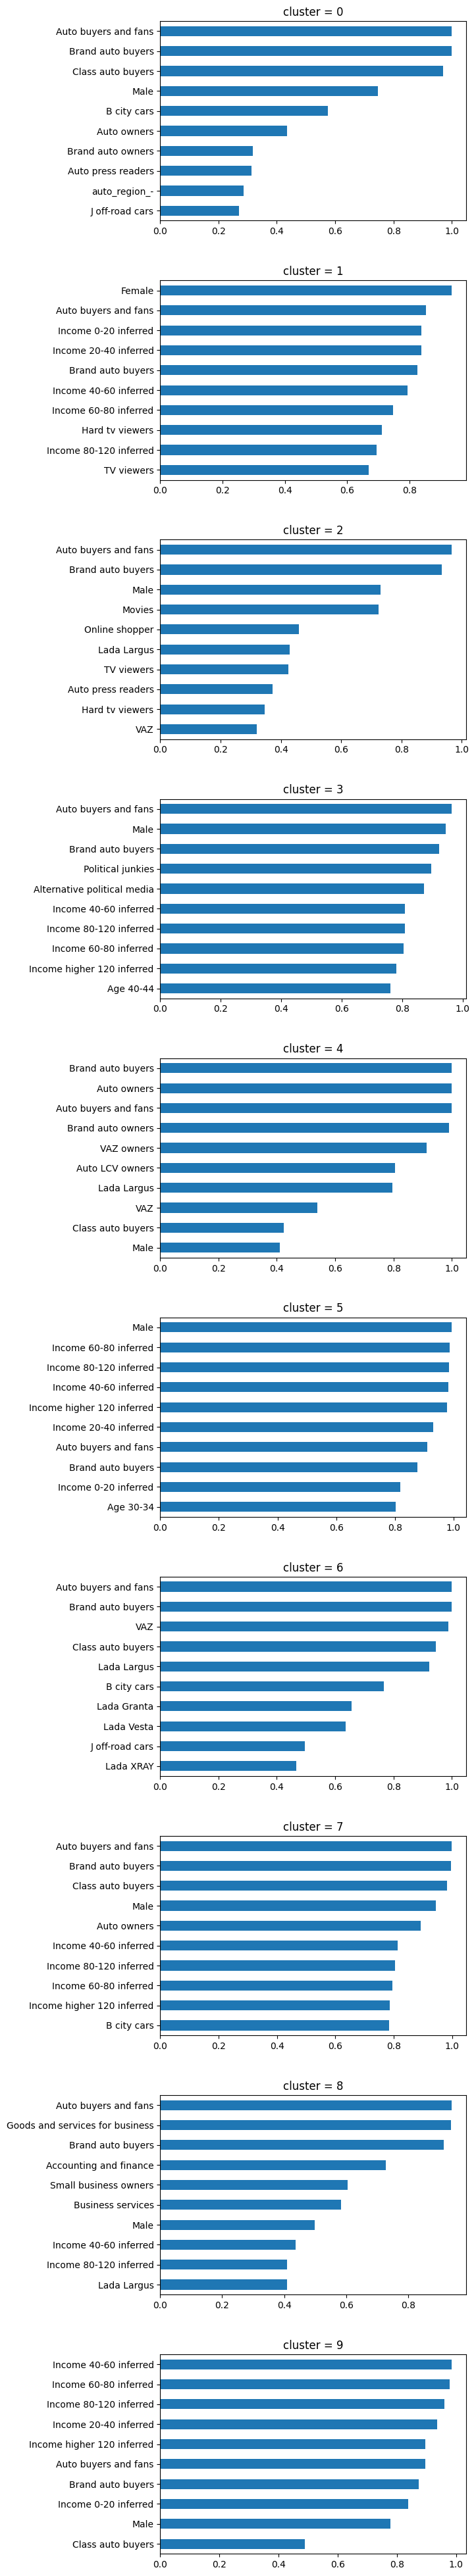

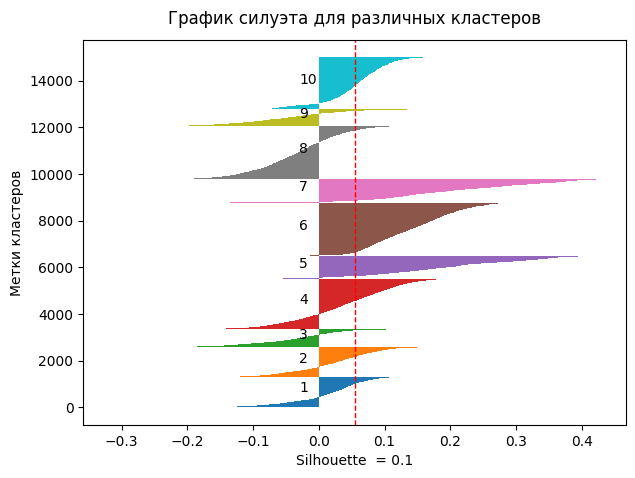

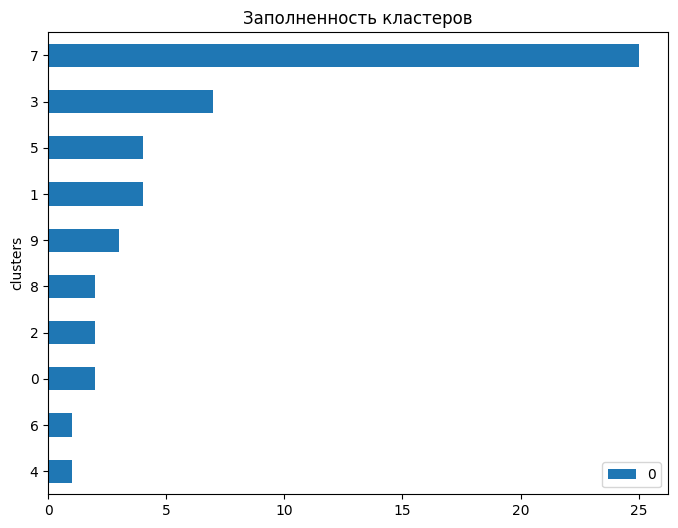

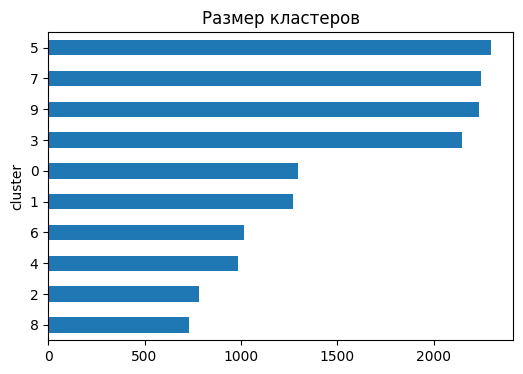

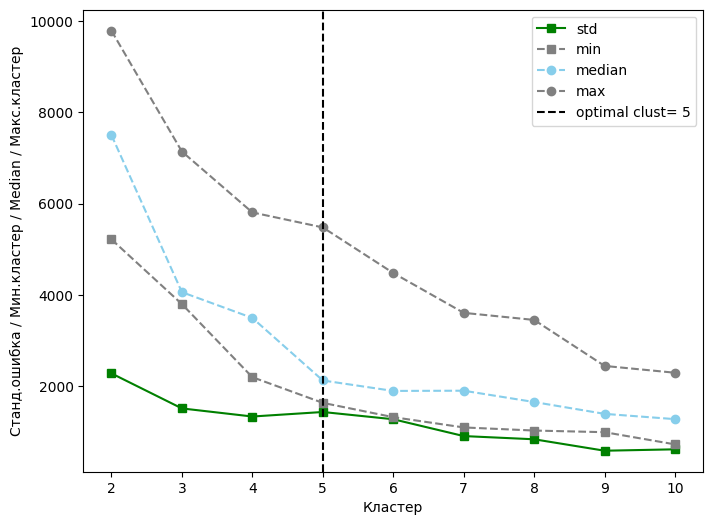

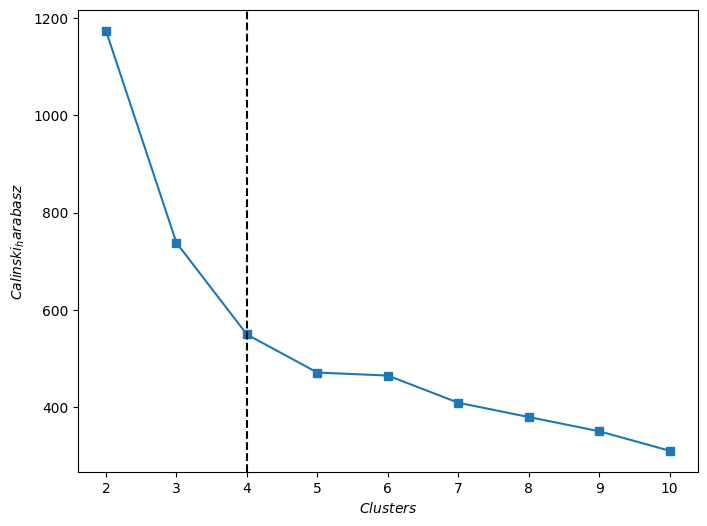

In [30]:
arr_std = []
arr_min = []
arr_median = []
arr_max = []
arr_calinski_harabasz = []
arr_silhouette = []

min_label = 2
max_label = 10

for n_clusters in range(min_label, max_label+1):
    model = SpectralClustering(
        n_clusters=n_clusters, affinity='cosine', n_jobs=-1)
    model.fit(df_sample)

    plot_top_features(df_sample, model.labels_, n_clusters)
    silhouette_plot(df_sample, model.labels_, metrics='cosine')
    check_fullness(df_sample, model.labels_)
    plot_size(df_sample, model.labels_)

    arr_calinski_harabasz.append(
        calinski_harabasz_score(df_sample, model.labels_))
    arr_silhouette.append(silhouette_score(
        df_sample, model.labels_, metric='cosine'))
    counts = np.unique(model.labels_, return_counts=True)
    arr_min.append(counts[1].min())
    arr_max.append(counts[1].max())
    arr_median.append(np.median(counts[1]))
    arr_std.append(np.std(counts[1]))

elbow_picture(labels_std=arr_std,
              labels_min=arr_min,
              labels_max=arr_max,
              labels_median=arr_median,
              type_optimal=arr_median,
              min_size=min_label,
              max_size=max_label)

metric_picture(arr_calinski_harabasz,
               min_size=min_label,
               max_size=max_label,
               name_metric="Calinski_harabasz")

9) Выбор оптимального кол-ва кластеров и вывод графиков:

- Выбрать оптимальное кол-во кластеров (основывайтесь на разных метриках, в том числе и на интерпретации) и обучите алгоритм спектральной кластеризации на df_sample (применять цикл не нужно)
- Отобразите эмбеддинги для df_sample на двумерном графике, цветами обозначьте метки новых кластеров

In [30]:
model = SpectralClustering(n_clusters=5, affinity='cosine', n_jobs=-1)
model.fit(df_sample)

labels = np.unique(model.labels_)

In [31]:
binary_label = df_sample.assign(cluster=model.labels_)
size_cluster = binary_label.groupby('cluster').count().iloc[:, 0]
data_sum = binary_label.groupby('cluster').sum()
data_sum_norm = data_sum.T / size_cluster * 100

<Axes: xlabel='cluster'>

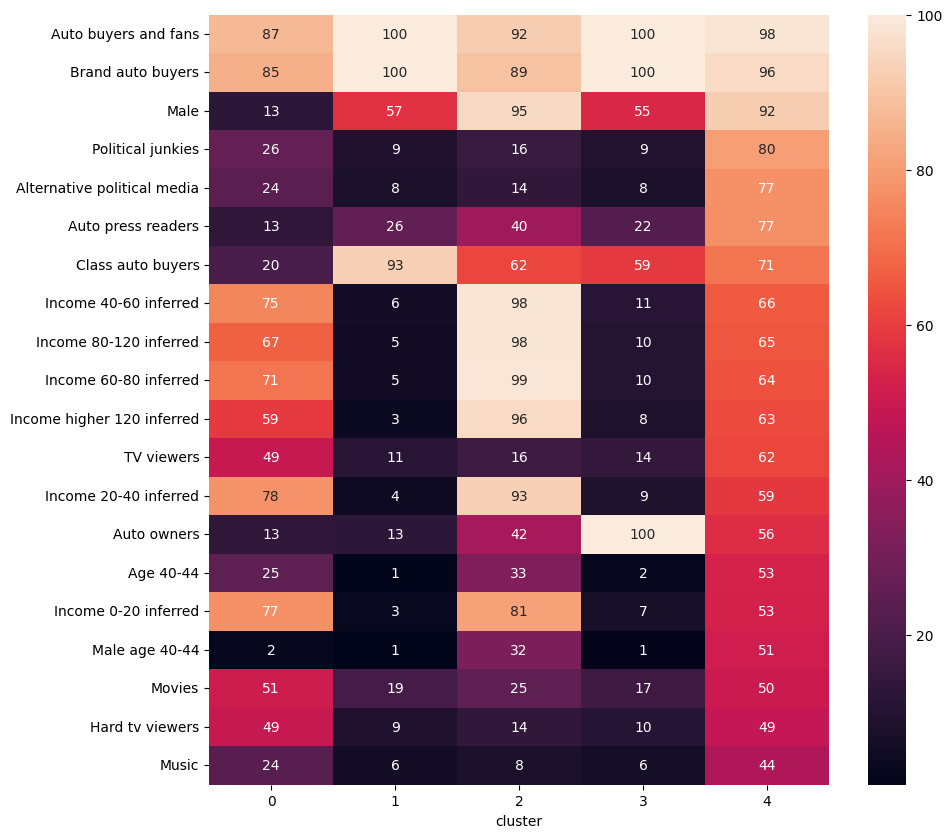

In [36]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_sum_norm.loc[:].sort_values(by=4, ascending=False)[:20], fmt='.0f', annot=True)

<AxesSubplot:>

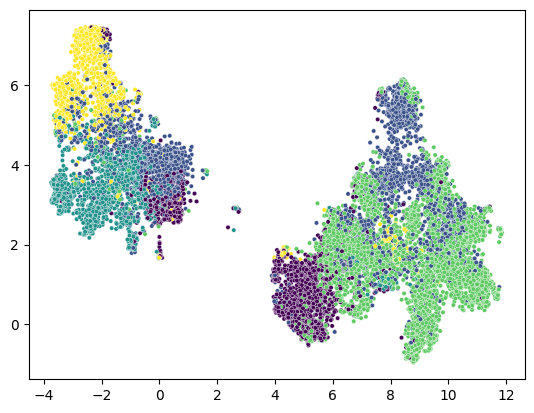

In [72]:
sns.scatterplot(x=x_embedding_sample[:,0], y=x_embedding_sample[:,1], s=10, c=model.labels_)

10) Интерпретация результатов

- Обучите алгоритм классификации (тут стоит выбрать самим) на данных метках кластера и df_sample
- Получите на датасете cleaned_dataset метки кластеров при помощи обученного алгоритма классификации
- Создайте новый датасет cleaned_dataset_spec копию cleaned_dataset, добавьте столбец target - кластеры, полученные в прошлом пункте
- Посчитайте кол-во объектов в каждом кластере, запишите в переменную count
- Отнормируйте кол-во объектов в каждом из признаков в кластере на общее кол-во объектов в кластере - count, запишите в переменную normalize
- Постройте heatmap для normalize heatmap и **опишите каждый кластер**

In [73]:
from sklearn.linear_model import LogisticRegression

In [74]:
lr = LogisticRegression(class_weight='balanced', random_state=RAND)
lr.fit(df_sample, model.labels_)

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=10)

In [75]:
y_pred = lr.predict(cleaned_dataset)
cleaned_dataset_spec = cleaned_dataset.copy()
cleaned_dataset_spec['target'] = y_pred

<AxesSubplot:xlabel='target'>

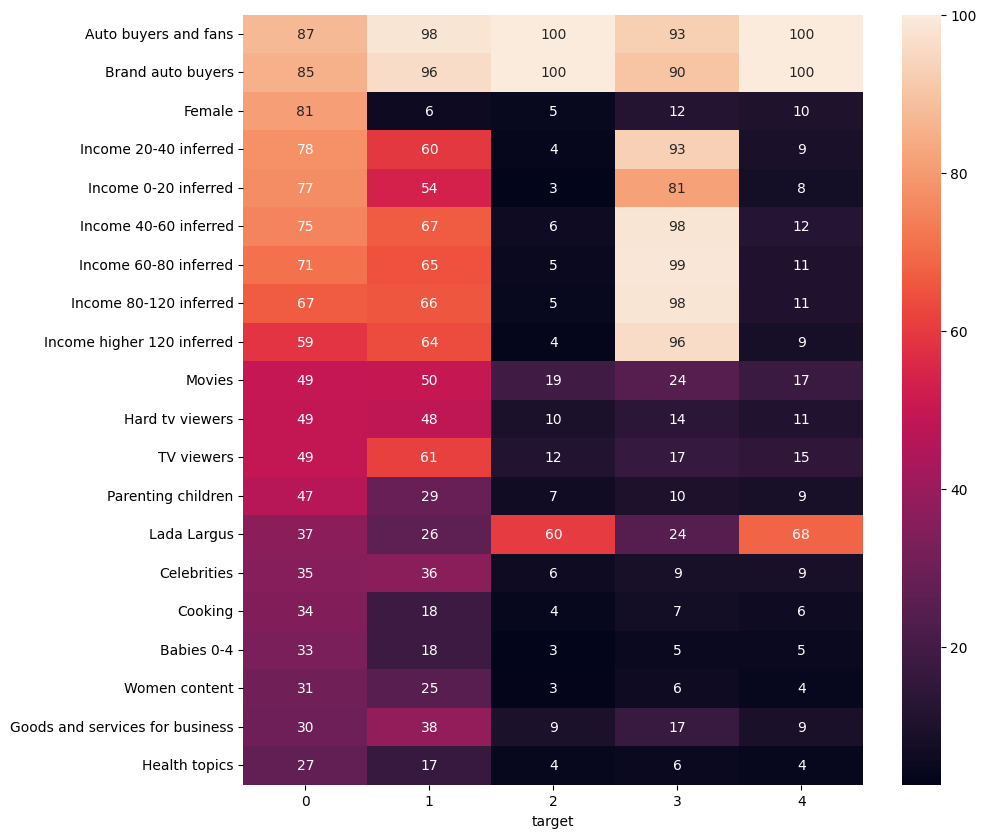

In [80]:
size_cluster = cleaned_dataset_spec.groupby('target').count().iloc[:, 0]
data_sum = cleaned_dataset_spec.groupby('target').sum()
data_sum_norm = data_sum.T / size_cluster * 100

plt.figure(figsize=(10, 10))
sns.heatmap(data_sum_norm.loc[:].sort_values(
    by=0, ascending=False)[:20], fmt='.0f', annot=True)

1 кластер: женщины-автолюбители
2 кластер: мужчины-автолюбители, интересующиеся политикой и читающие прессу 
3 кластер: автолюбители, посещающие интернет-страницы конкретных автомобилей 
4 кластер: мужчины-автолюбители с высоким доходом  
5 кластер: автолюбители, у которых уже есть автомобиль     

### DBSCAN

11) Так как для DBSCAN нет необходимости задавать кол-во кластеров то:

- 1) обучите DBSCAN на cleaned_dataset
- 2) Постройте графики при помощи функций plot_top_features, silhouette_plot, check_fullness, plot_size

Кластеры при DBSCAN нумеруются с -1, поэтому нужно быть аккуратнее при подачи в методы, возможно стоит добавить единицу к значению номера кластера

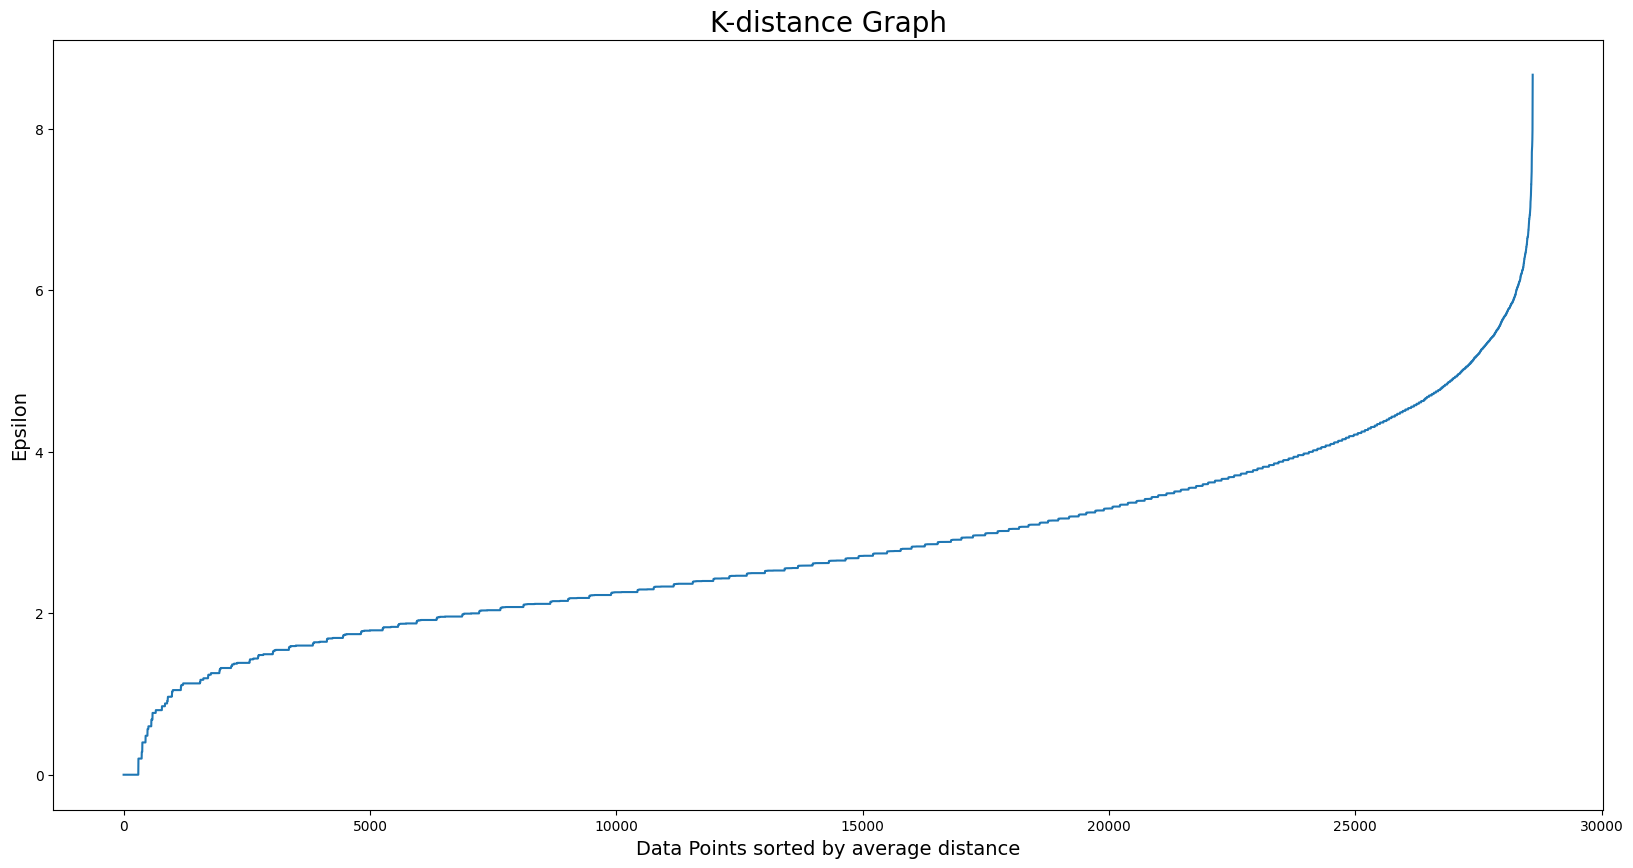

In [37]:
neigh = NearestNeighbors(n_neighbors = 5)
nbrs = neigh.fit(cleaned_dataset)
distances, indices = nbrs.kneighbors(cleaned_dataset)

# Отобразим график расстояний между точками
distances = distances.mean(axis=1)
distances = np.sort(distances)

plt.figure(figsize = (20, 10))
plt.plot(distances)
plt.title('K-distance Graph', fontsize = 20)
plt.xlabel('Data Points sorted by average distance', fontsize = 14)
plt.ylabel('Epsilon', fontsize = 14)
plt.show()

In [38]:
model = DBSCAN(eps=6, min_samples=5, n_jobs=-1)
model.fit(cleaned_dataset)

DBSCAN(eps=6, n_jobs=-1)

In [39]:
np.unique(model.labels_)

array([-1,  0])

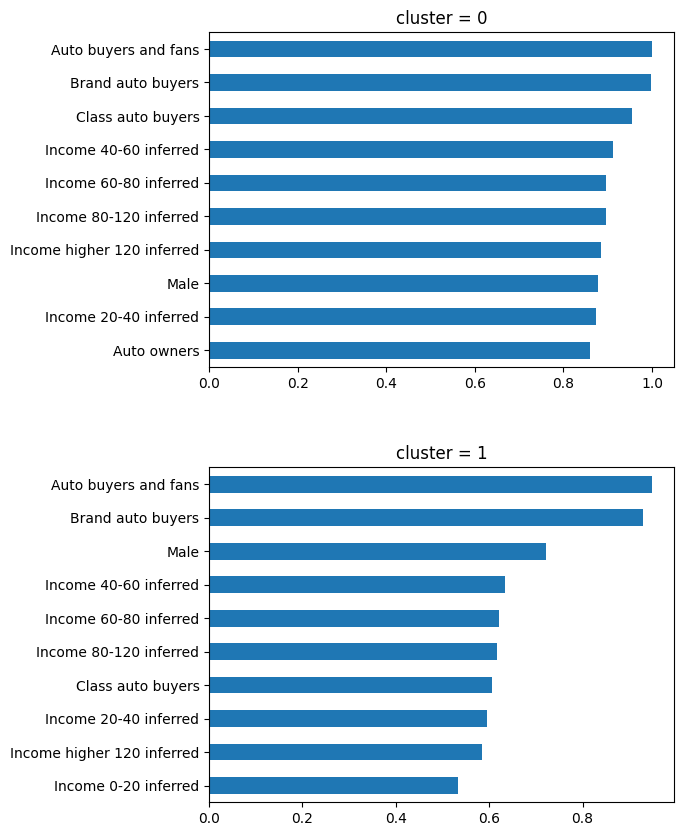

In [40]:
clusters = np.unique(model.labels_).shape[0]
plot_top_features(cleaned_dataset, model.labels_ + 1, clusters)

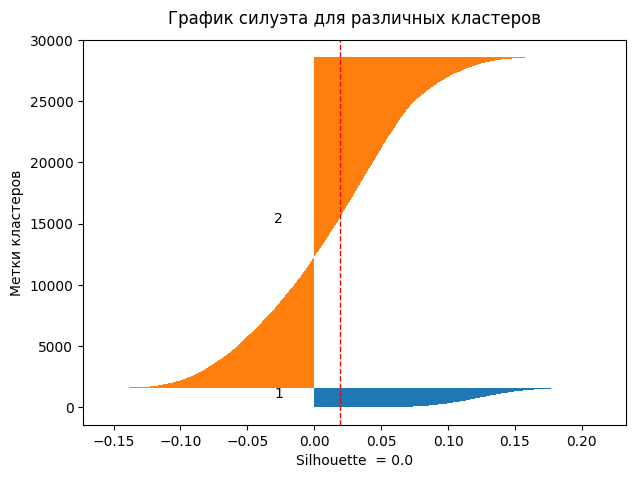

In [41]:
silhouette_plot(cleaned_dataset, model.labels_ + 1, metrics='cosine')

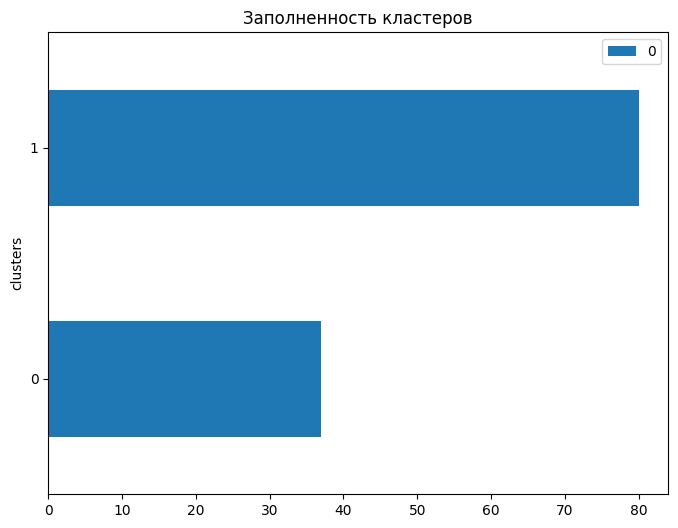

In [42]:
check_fullness(cleaned_dataset, model.labels_ + 1)

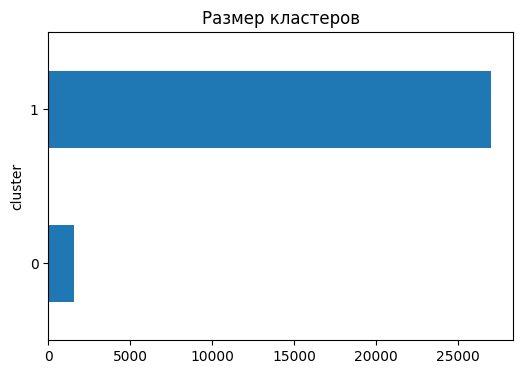

In [43]:
plot_size(cleaned_dataset, model.labels_ + 1)

Эвристика по поиску оптимальных eps и min_samples в DBSCAN не дала хороших результатов. Алгоритм может быть просто не эффективен в данной ситуации, так как матрица объект-признаки является разреженной и имеет большую размерность.(другие значения, подобранные вручную также не дали удовлетворительных результатов) 

In [44]:
model = DBSCAN(eps=3.4, min_samples=5, n_jobs=-1)
model.fit(cleaned_dataset)

DBSCAN(eps=3.4, n_jobs=-1)

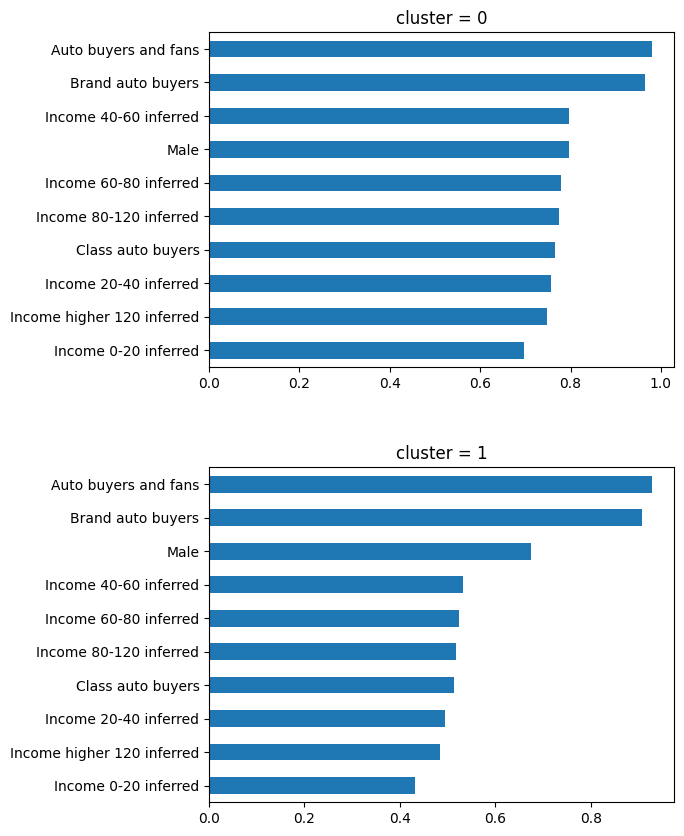

In [45]:
clusters = np.unique(model.labels_).shape[0]
plot_top_features(cleaned_dataset, model.labels_ + 1, clusters)

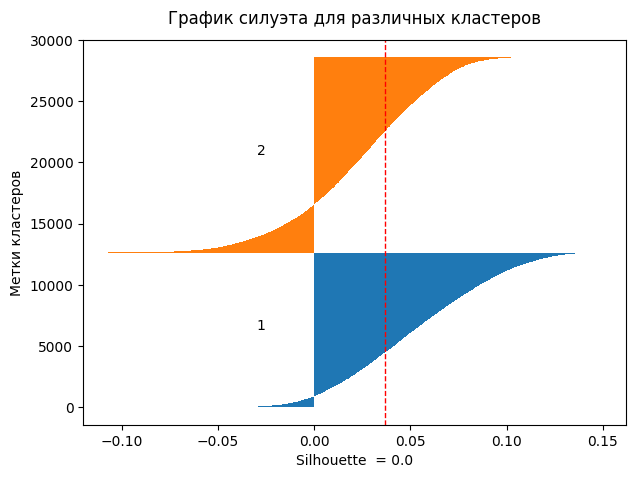

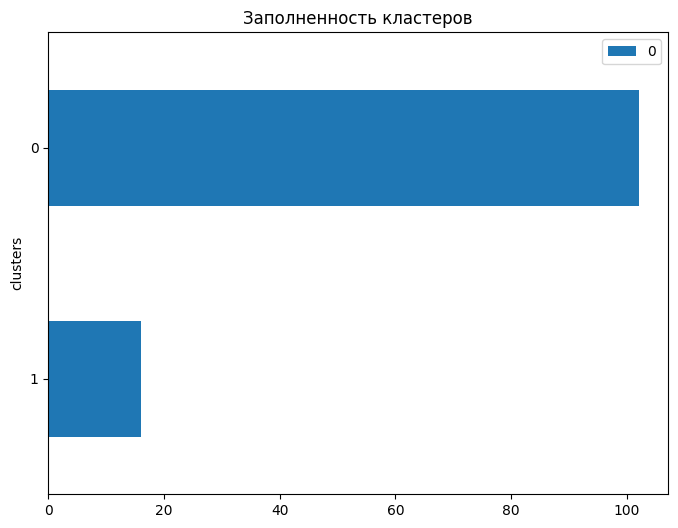

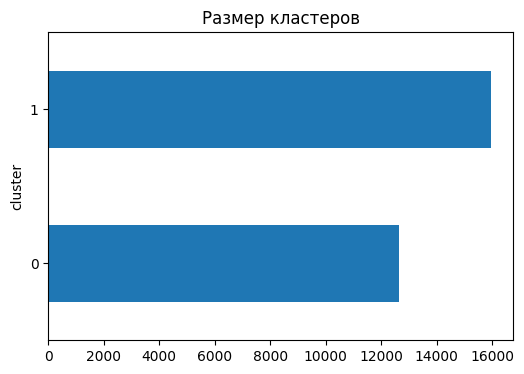

In [46]:
silhouette_plot(cleaned_dataset, model.labels_ + 1, metrics='cosine')
check_fullness(cleaned_dataset, model.labels_ + 1)
plot_size(cleaned_dataset, model.labels_ + 1)

При данных гиперпараметрах алгоритм, видимо, выделил 2 класса на основе заполненности объектов. Ценности такие кластеры не представляют, однако силуэтный коэффициент лучше, чем в предыдущем случае

12) 

- Сколько кластеров вы получили? Похоже ли на тот результат, что выдала спектральная кластеризация
- Отобразите эмбеддинги на двумерном графике, цветами обозначьте метки новых кластеров

<AxesSubplot:>

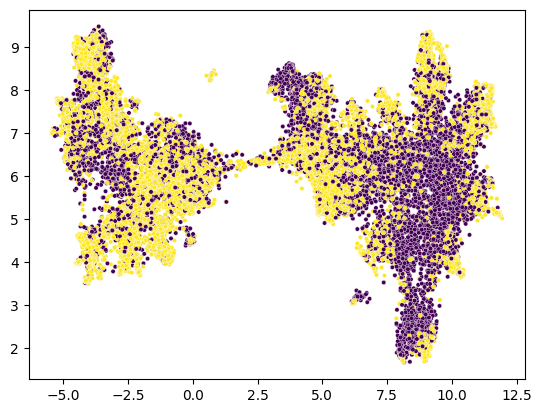

In [47]:
sns.scatterplot(x=x_embedding[:, 0],
                y=x_embedding[:, 1], s=10, c=model.labels_)

Алгоритм выдает различное кол-во кластеров в зависимости от гиперпараметров eps и min_samples. Относительно высокое качество при оптимальных гиперпараметрах алгоритм выдает при выделение 2 кластеров.

### KMeans

13) Выбор кол-ва кластеров на основании KMeans

- 1) создайте пустые списки для: 
    - значения стандартной ошибки, min, median и max кол-ва объектов в кластере
    - метрики calinski_harabasz
    - silhouette
- 2) В цикле вам необходимо от 2 до 10 кластеров сделать следующие действия:
    - 2.1) обучить алгоритм KMeans на кол-ве кластеров на текущем шаге цикла, использовать именно полученный датасет из задания 6 - cleaned_dataset
    - 2.2) вывести график топ фичей при помощи функции plot_top_features(), подав на вход cleaned_dataset, размеченные метки кластеров (пример clf.labels_) а также кол-во кластеров на текущем шаге цикла
    - 2.3) вывести график силуэтного скора при помощи функции silhouette_plot(), подав на вход cleaned_dataset, размеченные метки кластеров (пример clf.labels_)
    - 2.4) вывести график заполенности при помощи функции check_fullness(), подав на вход cleaned_dataset, размеченные метки кластеров (пример clf.labels_)
    - 2.5) вывести график размеров кластеров при помощи функции plot_size(), подав на вход cleaned_dataset, размеченные метки кластеров (пример clf.labels_)
    - 2.6) Добавить в списки для calinski_harabasz, silhouette соответствующие значения метрик, для silhouette использовать **косинусную метрику при вычислении значения**
    - 2.7) как в примере из лекций вычислить кол-во уникальных объектов в каждом кластере (_, counts = np.unique(clf.labels_, return_counts=True))
    - 2.8) найти стандартную ошибку, min, median и max кол-во объектов в кластере, используя предыдущий пункт, и записать в соответствующие ранее объявленные списки
- 3) после самого цикла вывести графики:
    - 3.1) зависимостей стандартной ошибки + min + median + max при помощи функции elbow_picture(), подав на вход списки, которые заполняли в цикле на шаге 2.7 
    - 3.2) Изменение метрики calinski_harabasz в зависимости от кол-ва кластеров, используя метод metric_picture
    - 3.3) Изменение метрики silhouette в зависимости от кол-ва кластеров, используя метод metric_picture
    
**Важно** везде используйте датасет из задания 6, даже для подачи в разные метрики

**P.S. считается долго, можно пойти пока попить кофе/чай =)**

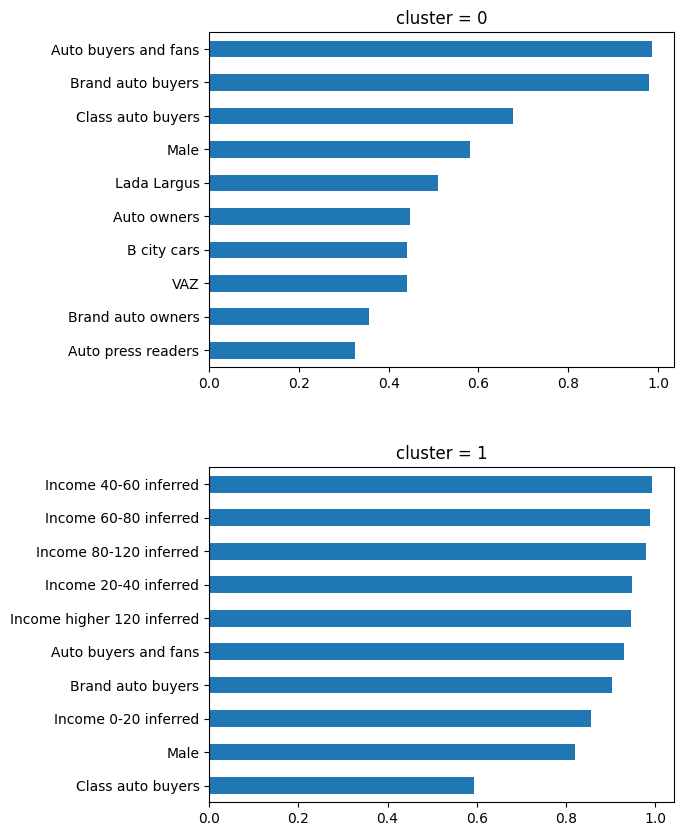

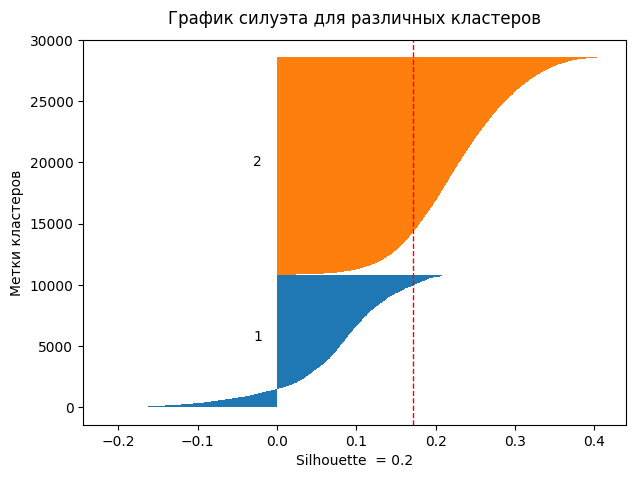

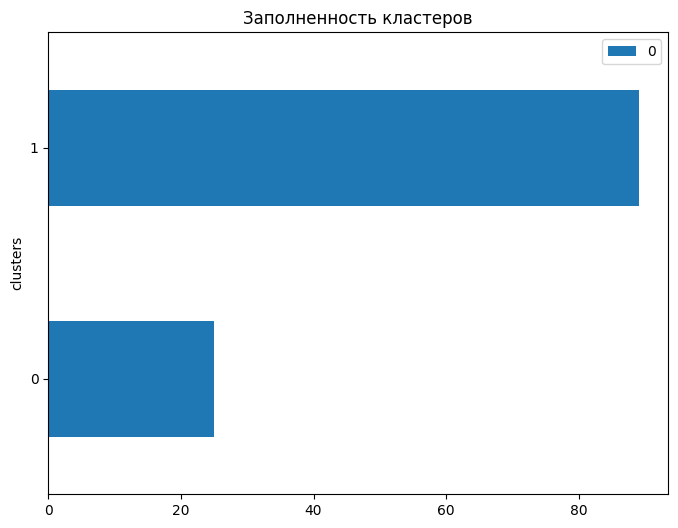

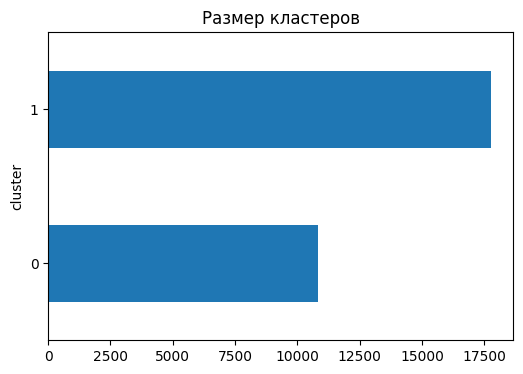

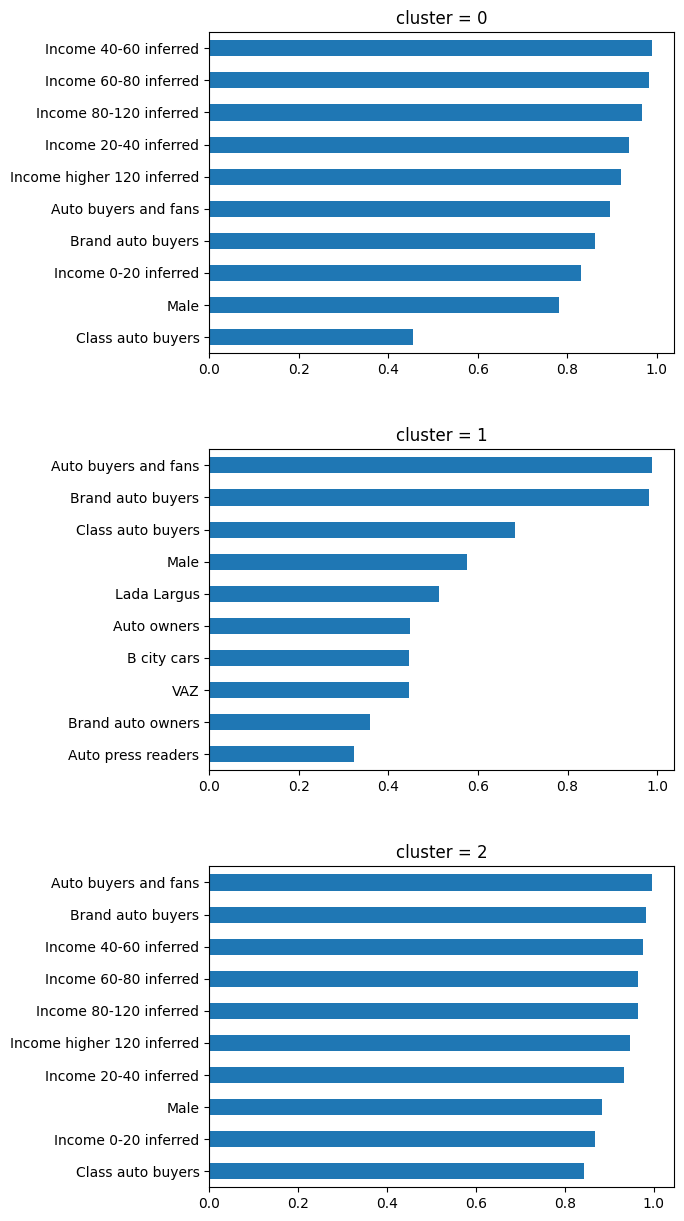

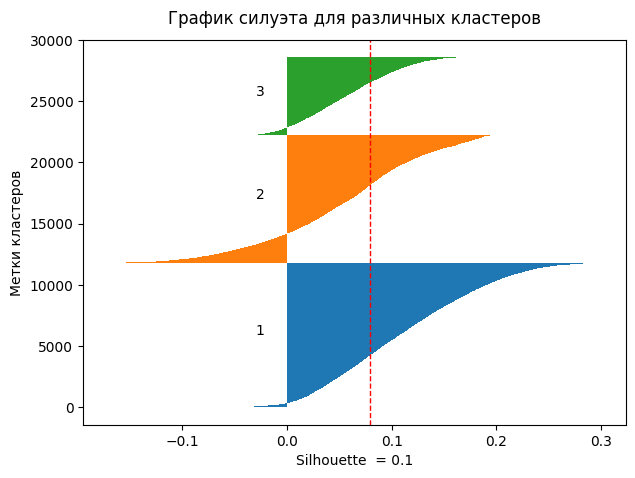

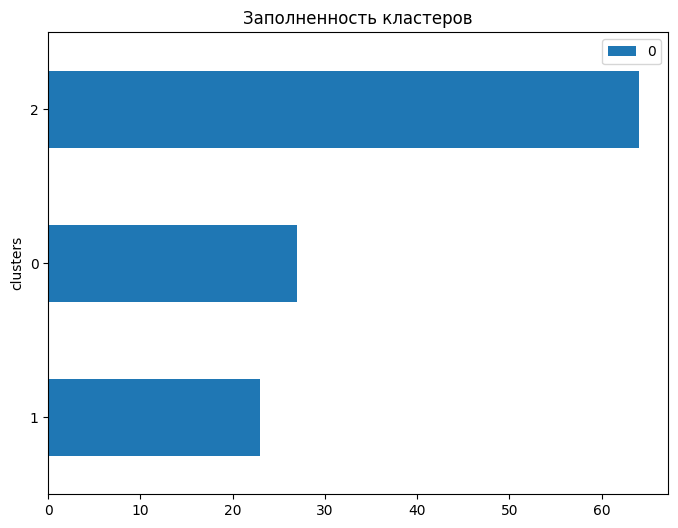

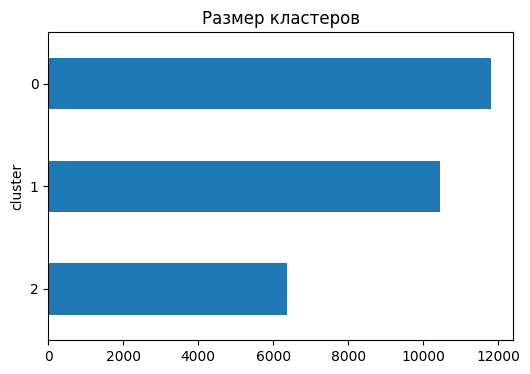

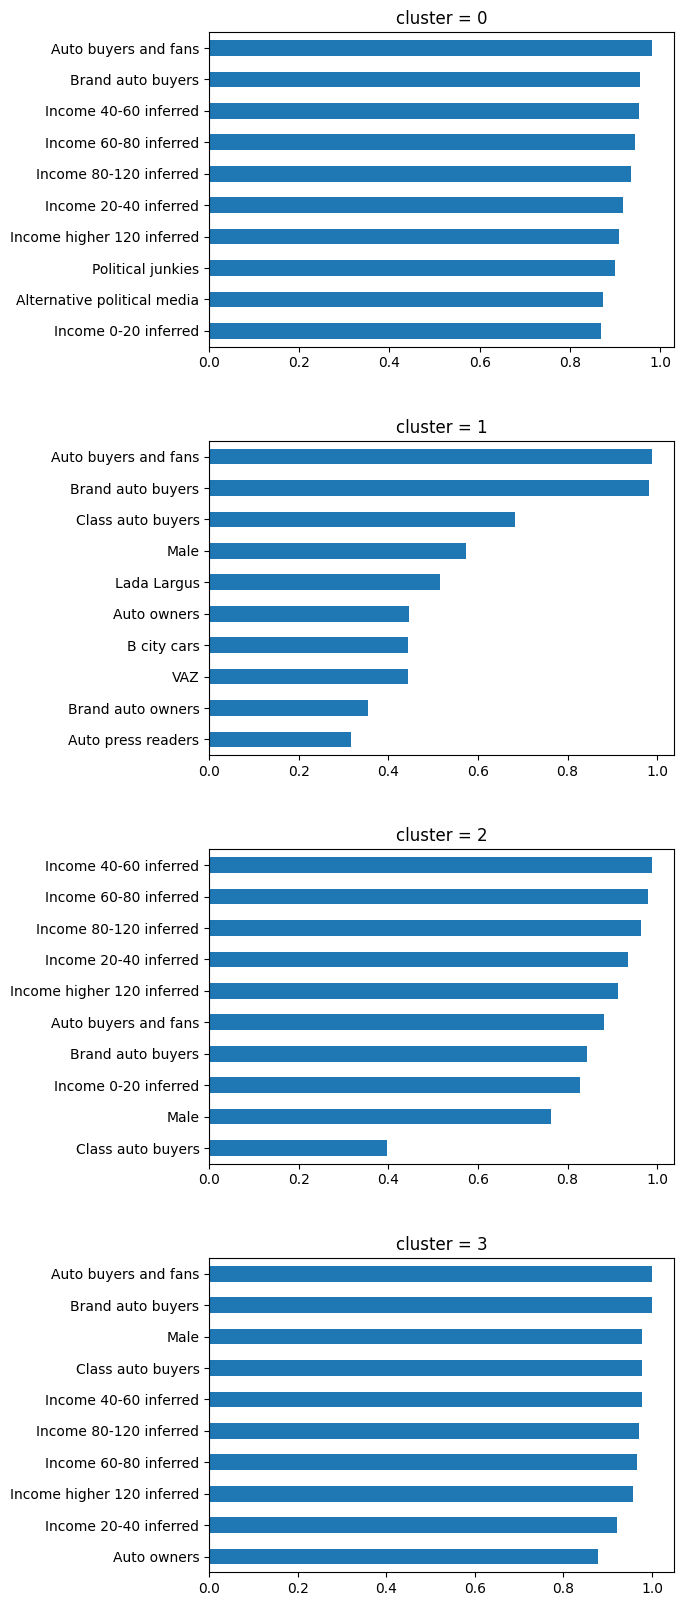

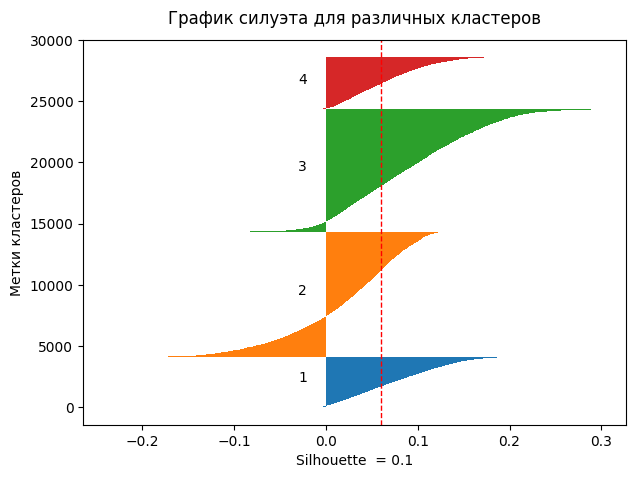

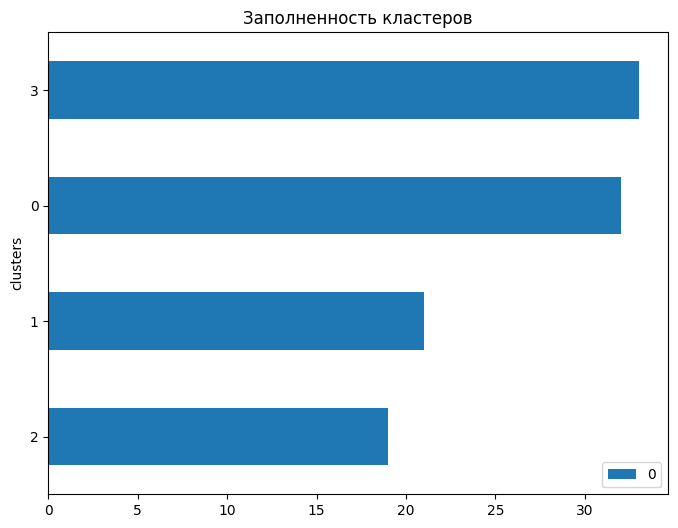

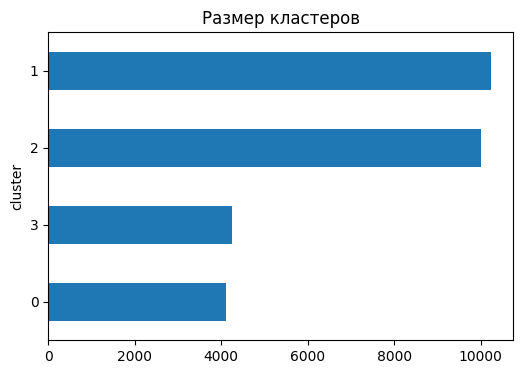

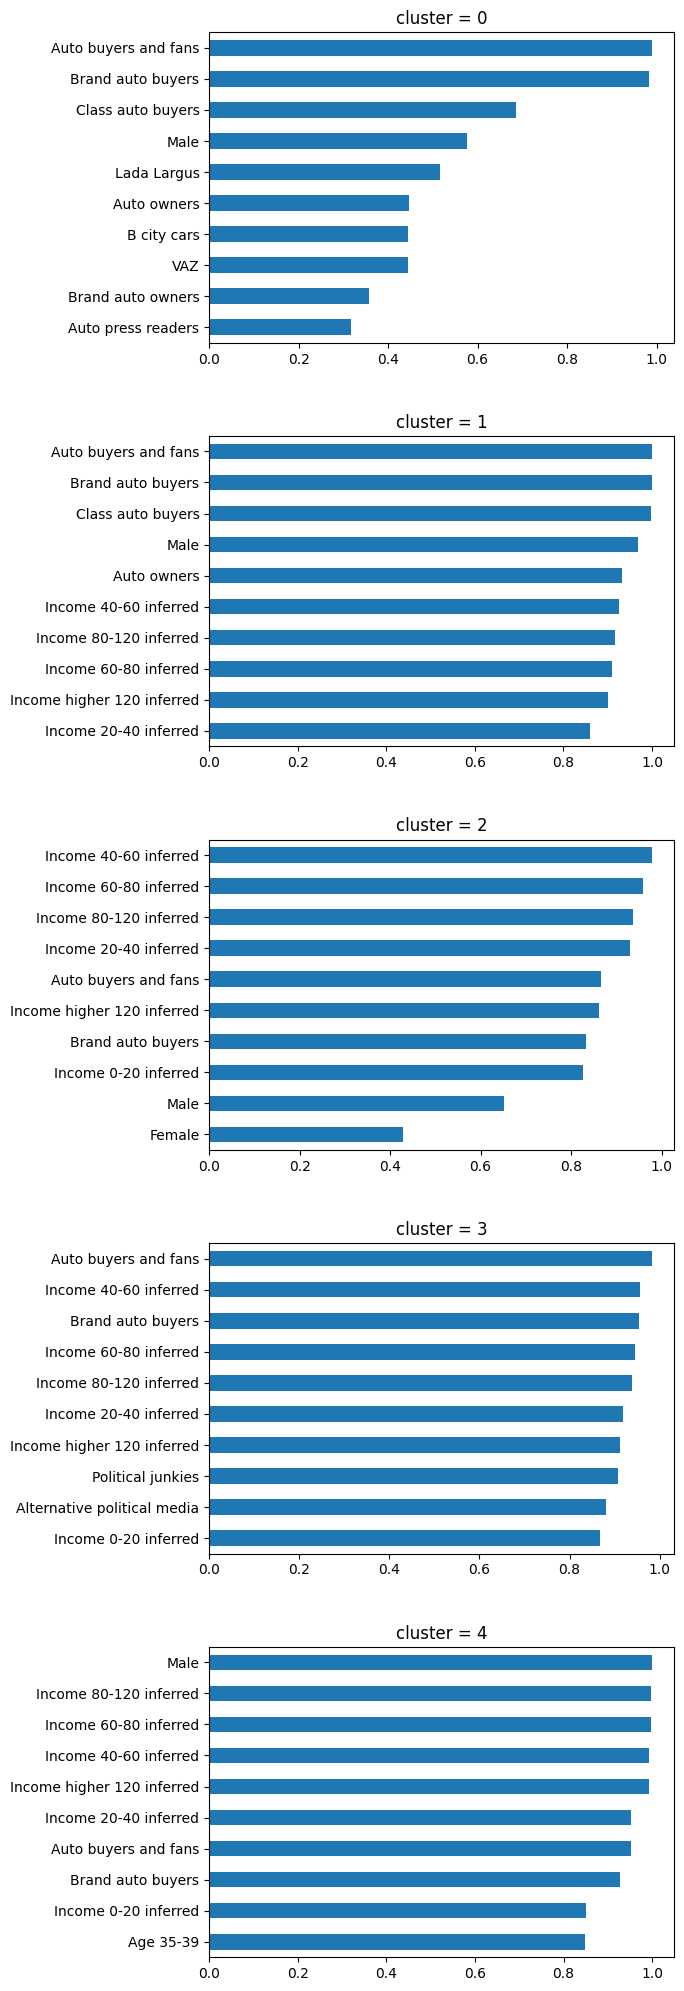

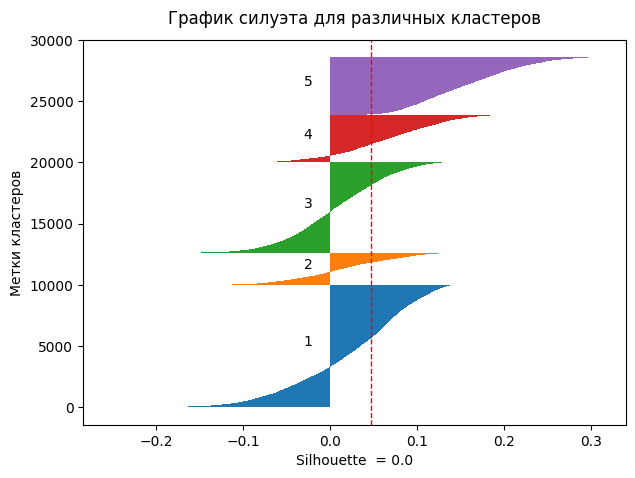

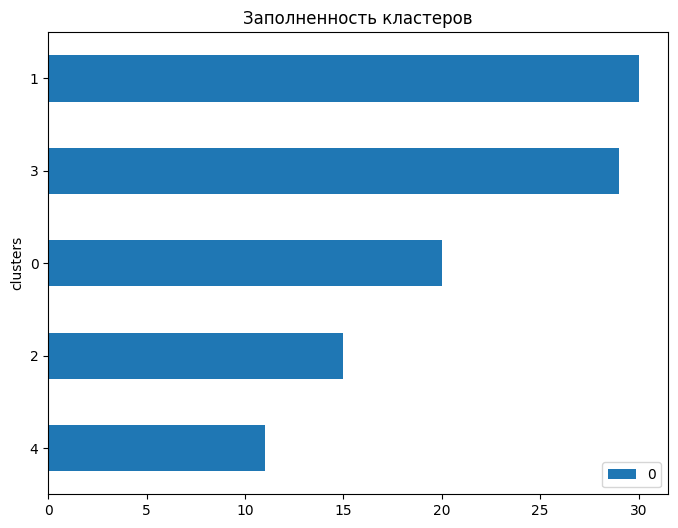

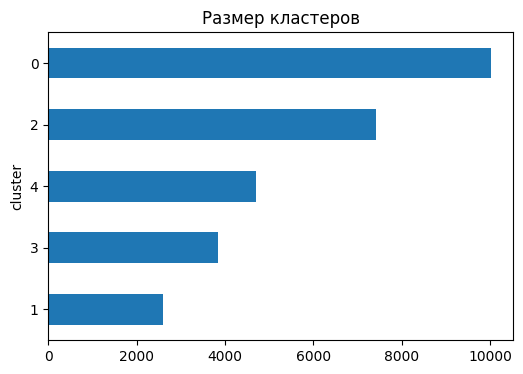

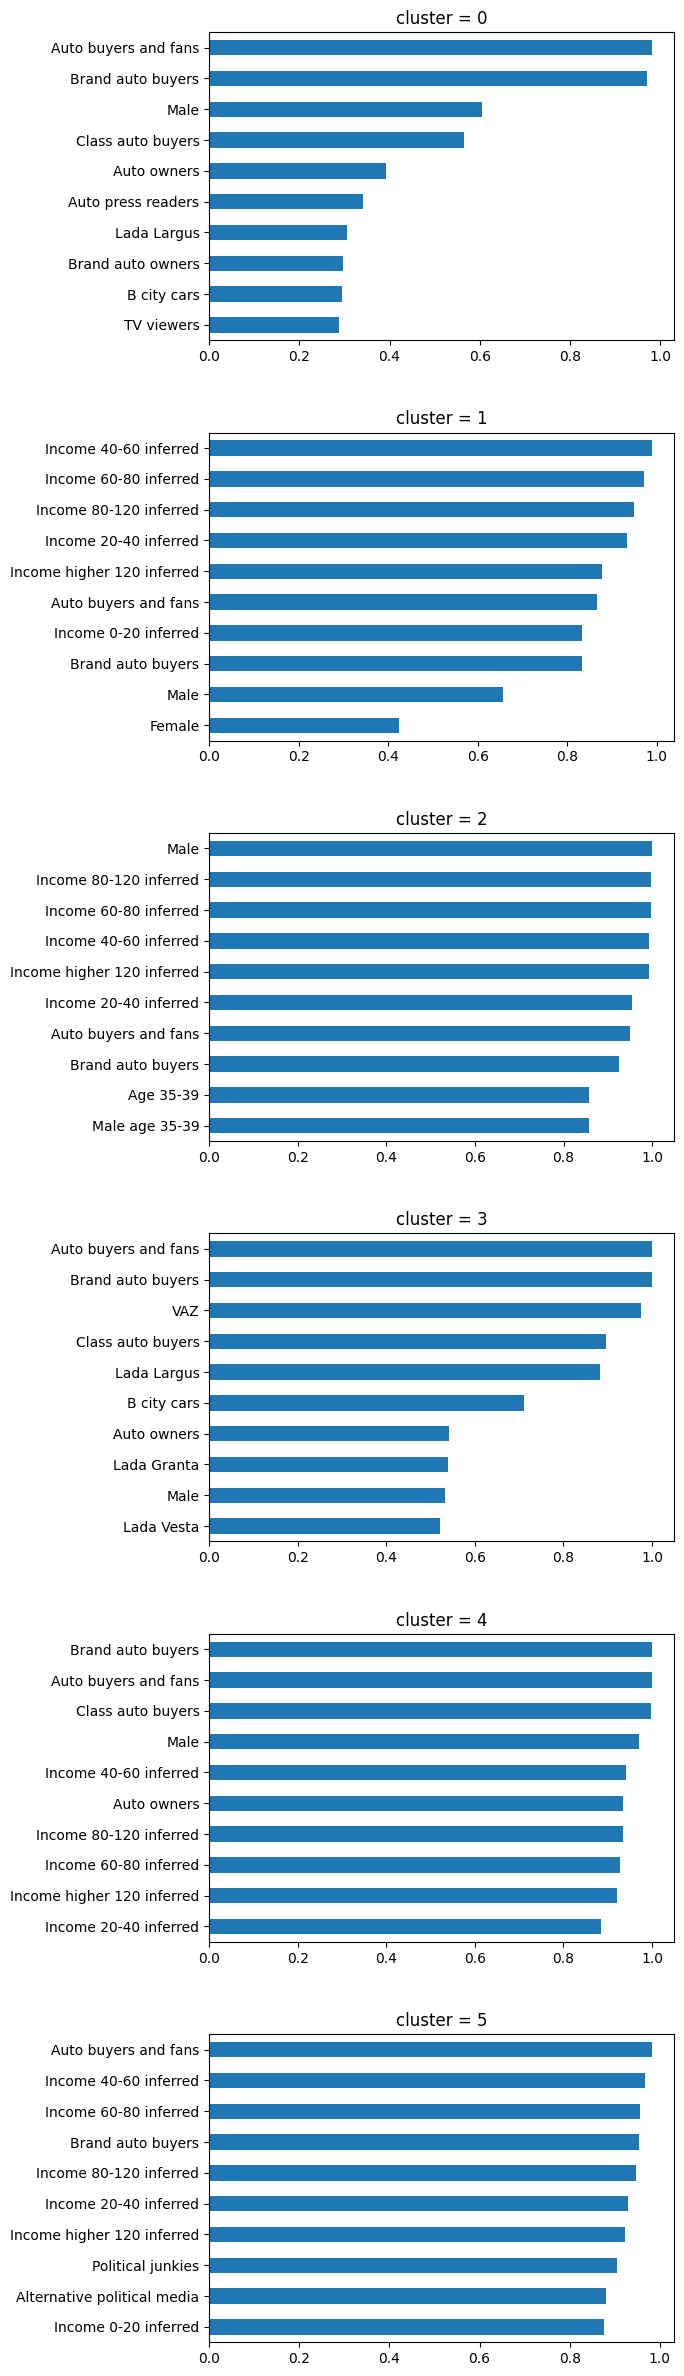

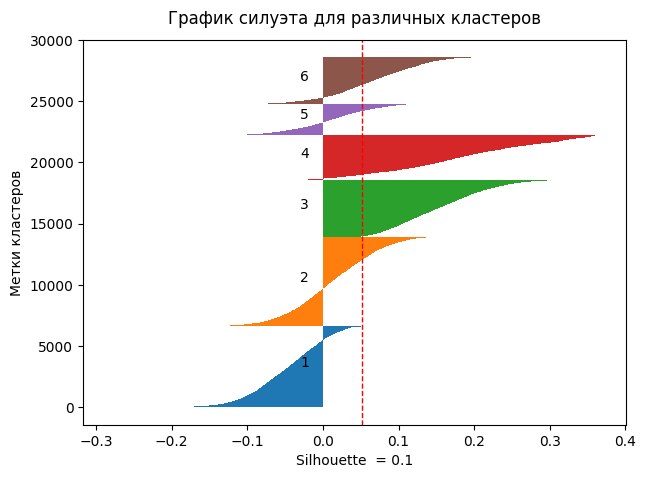

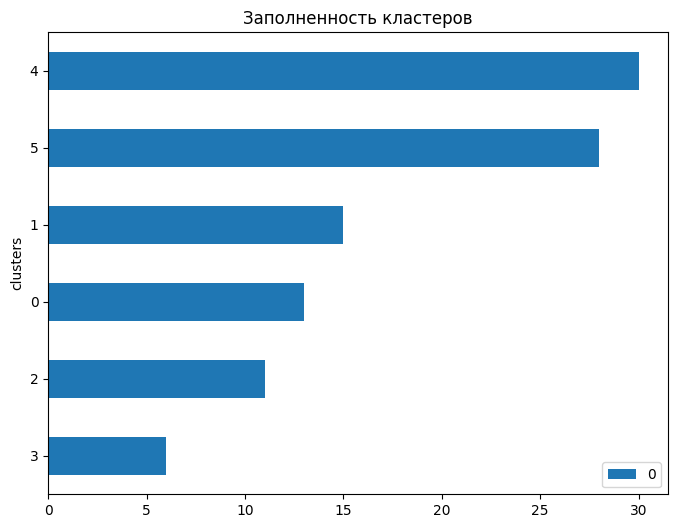

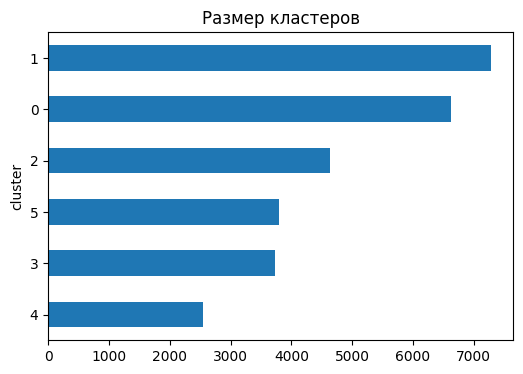

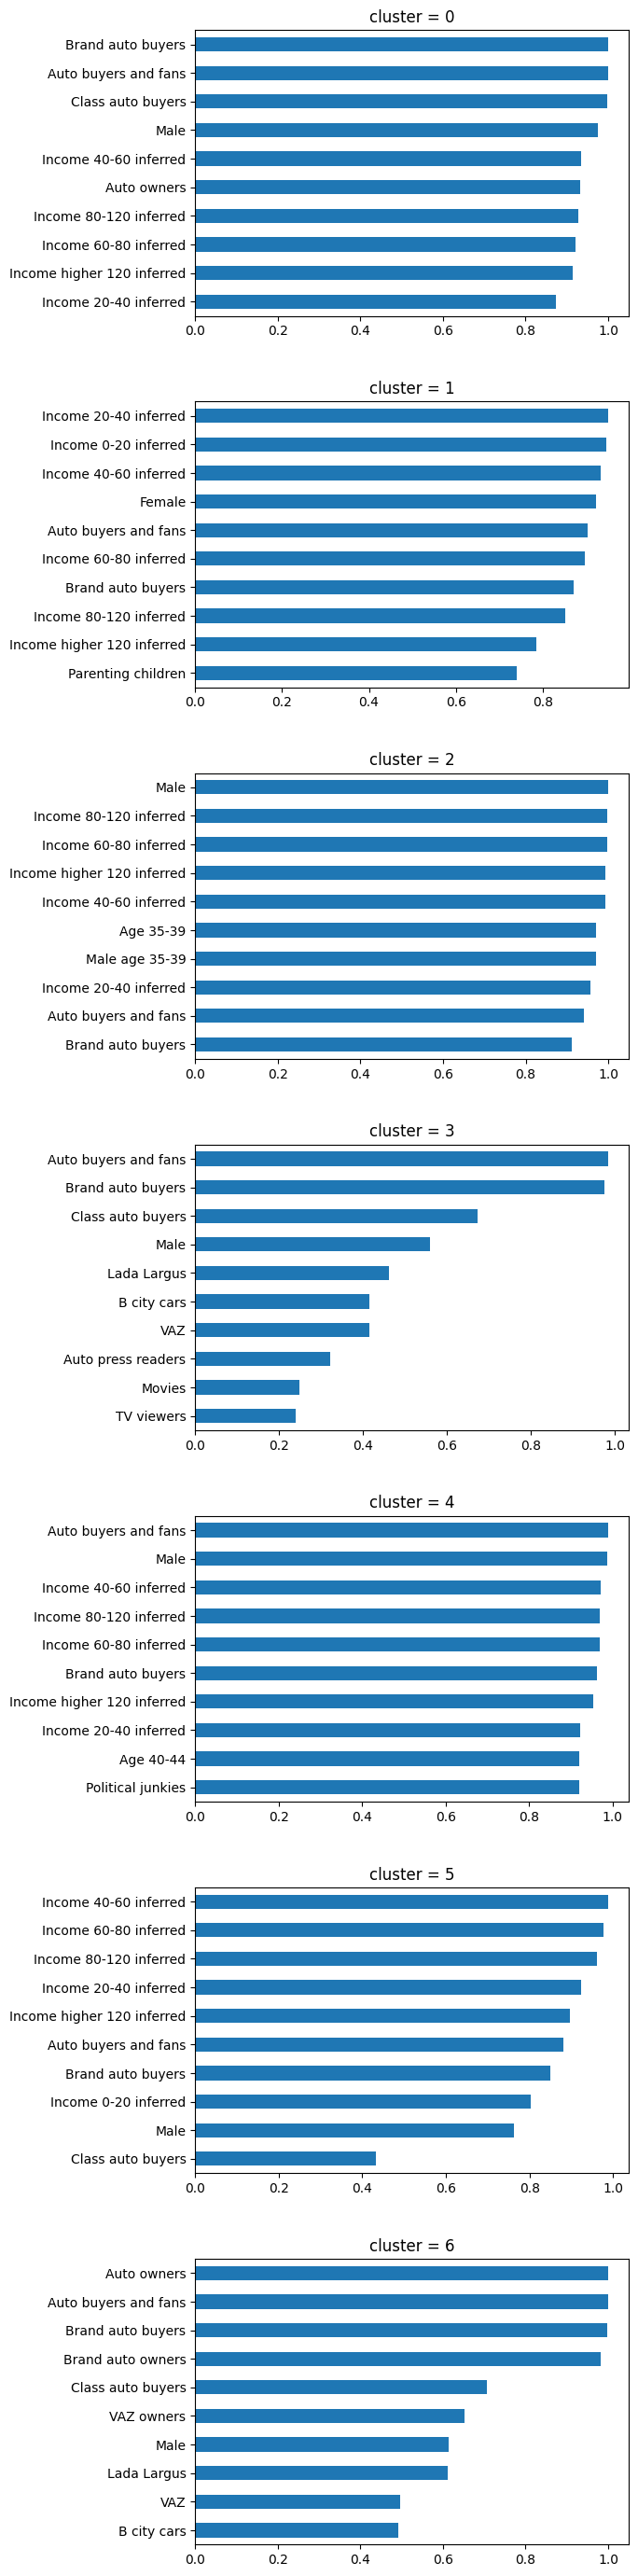

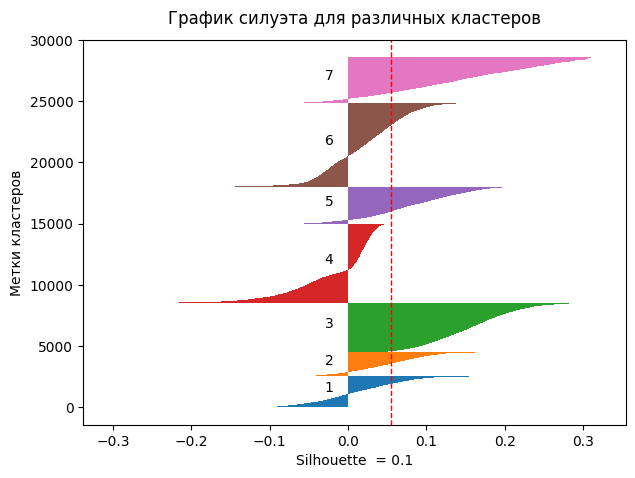

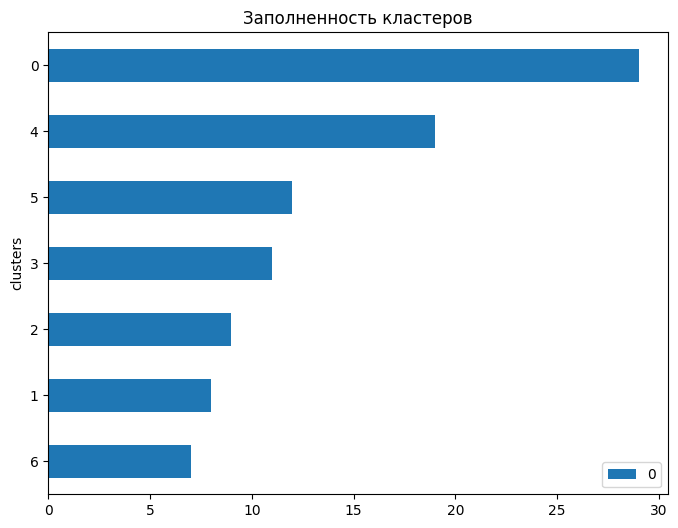

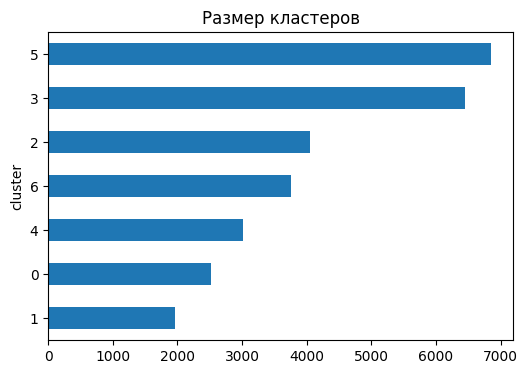

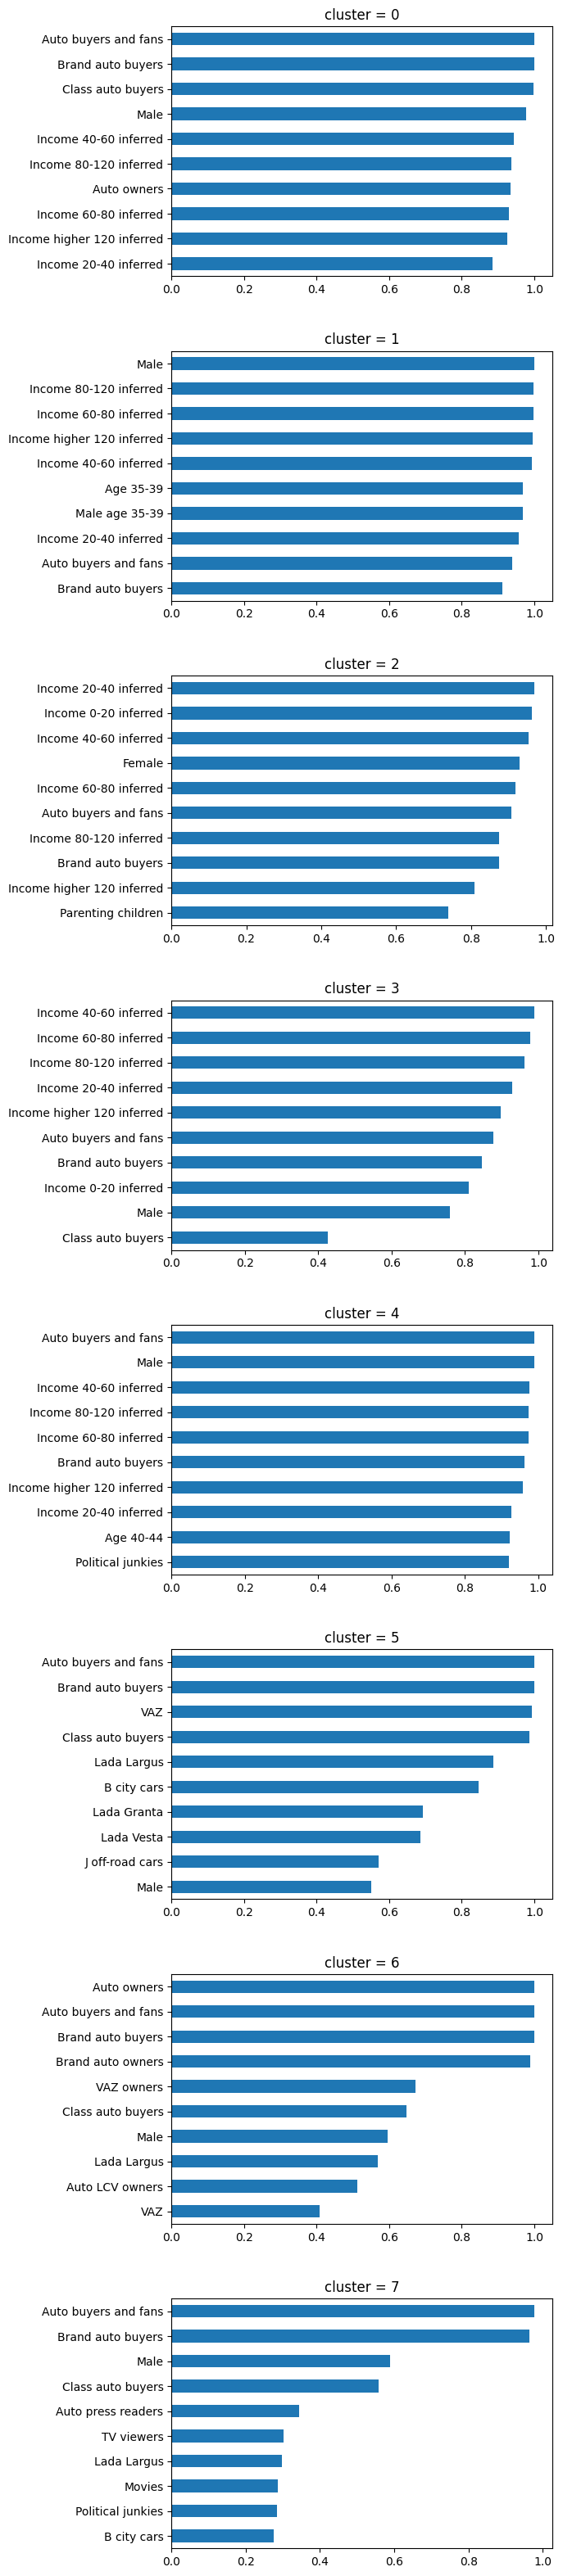

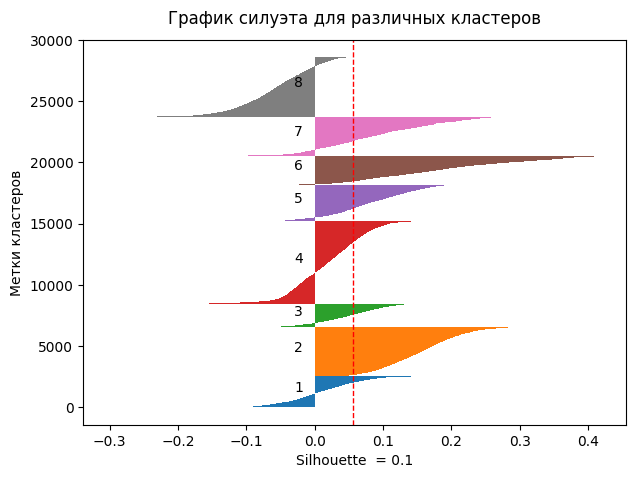

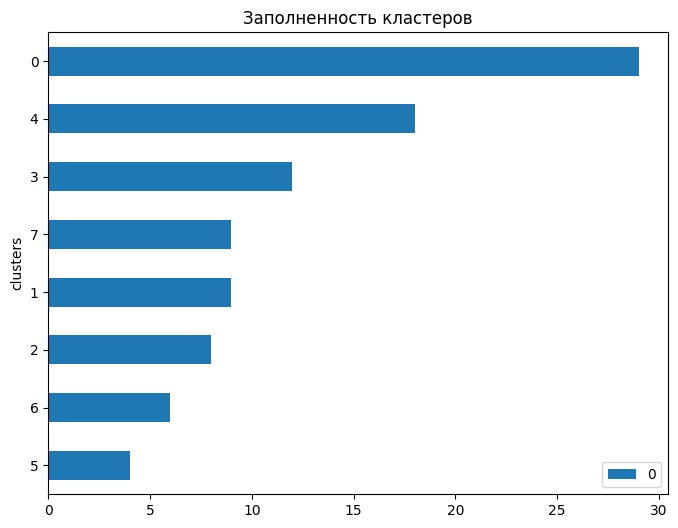

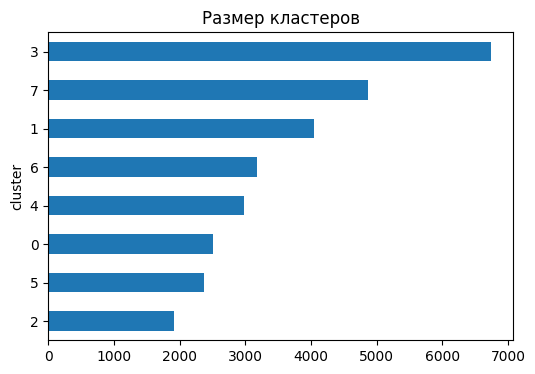

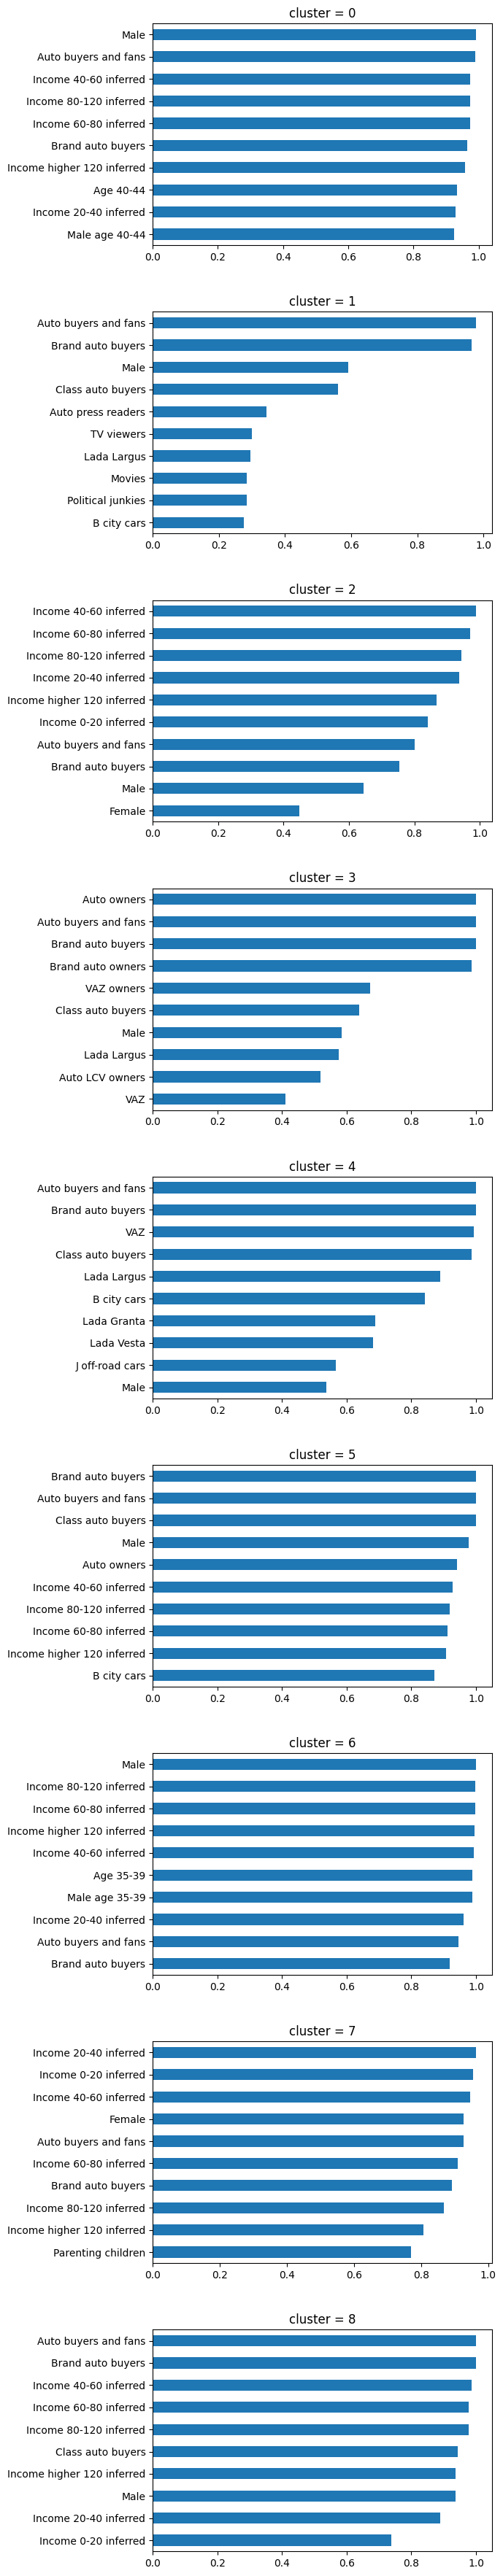

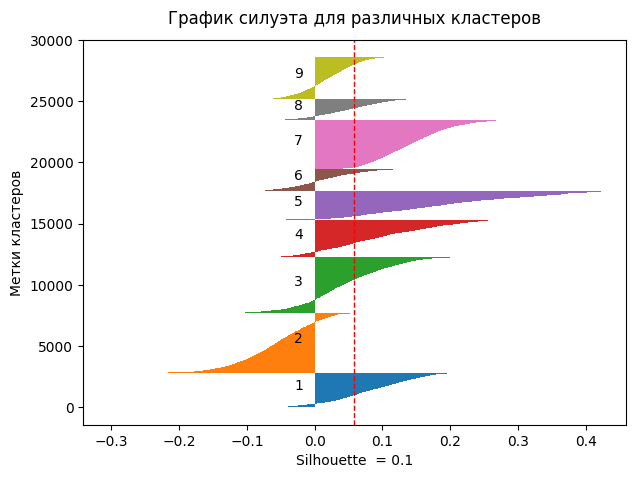

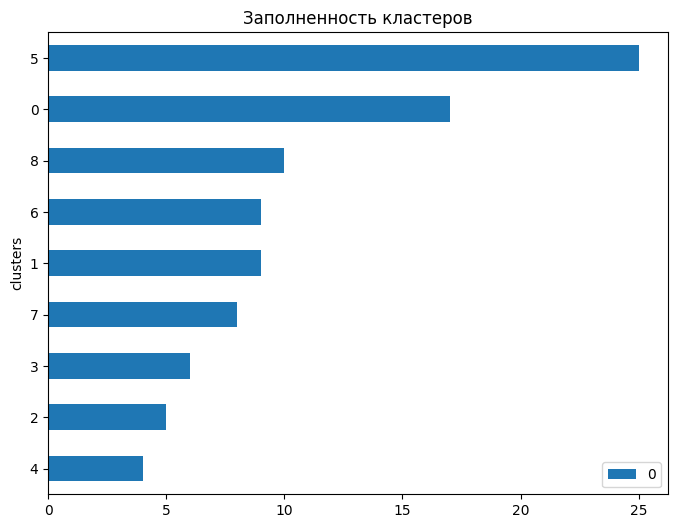

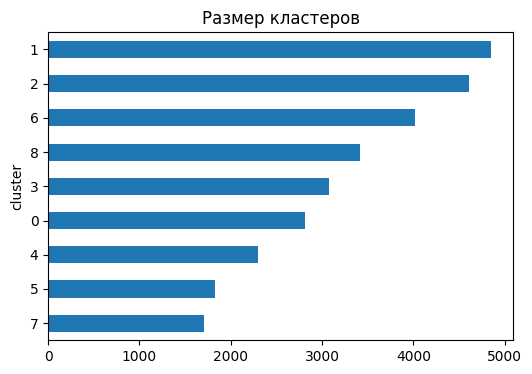

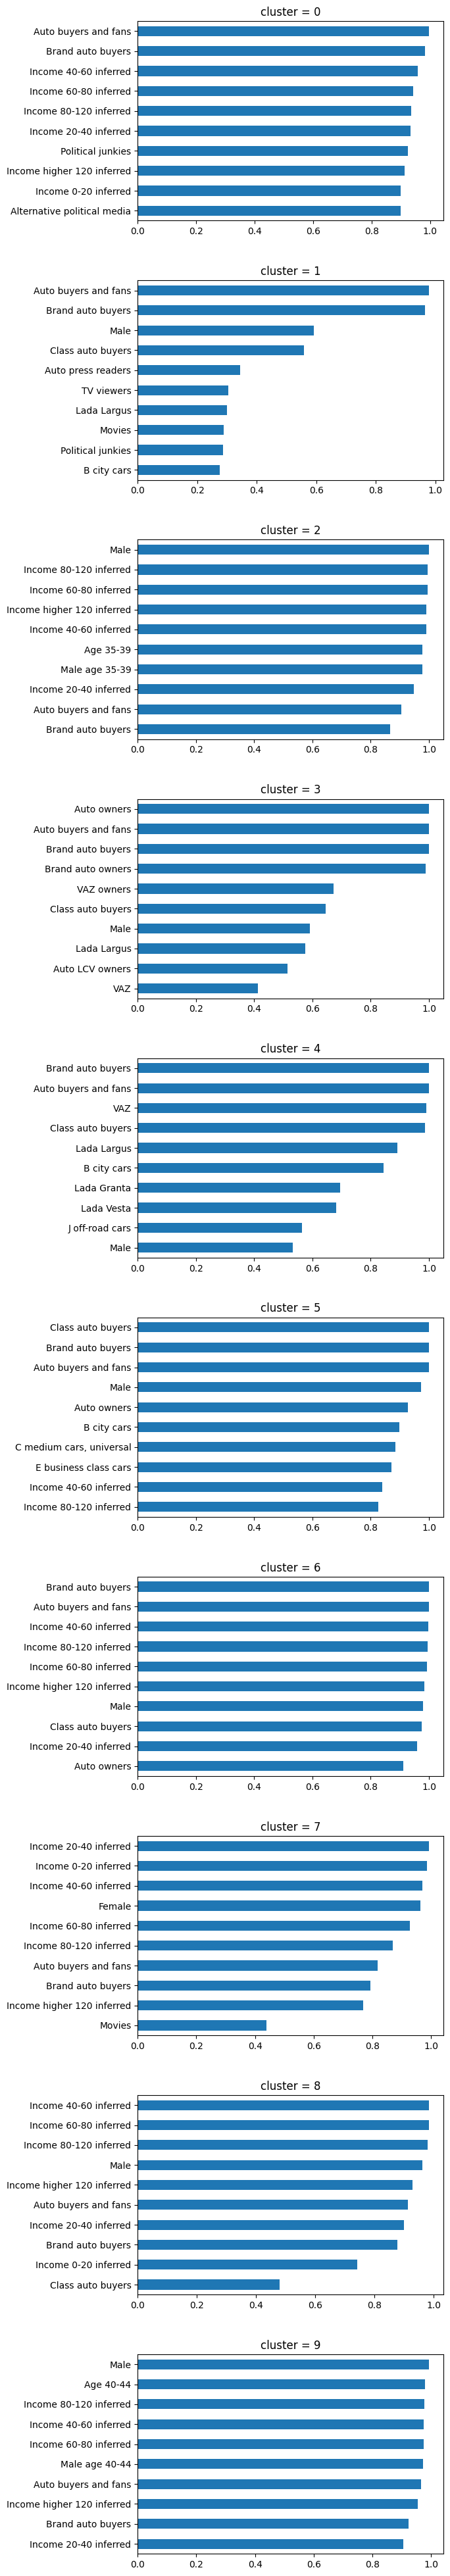

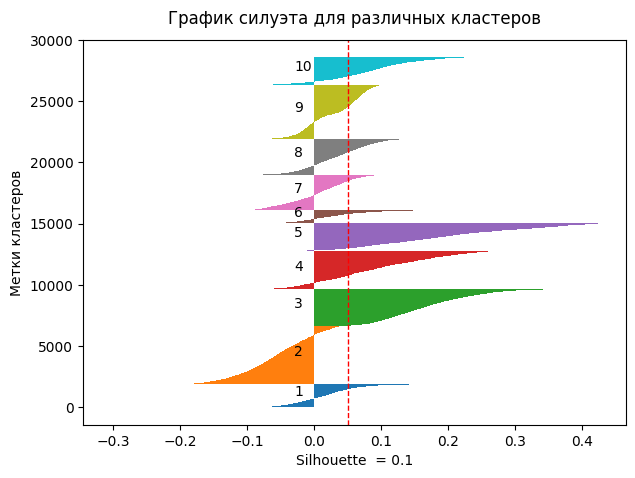

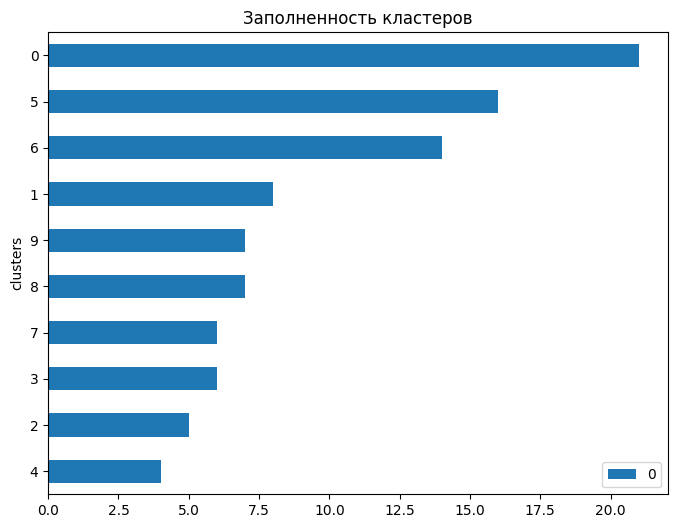

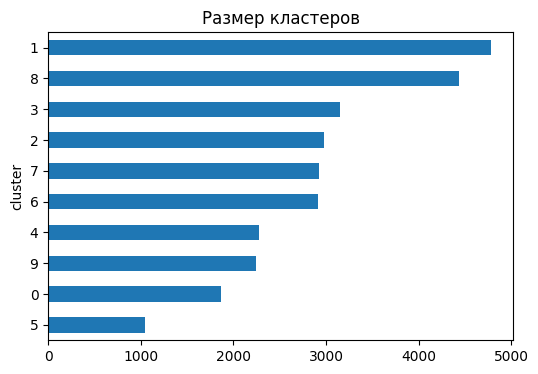

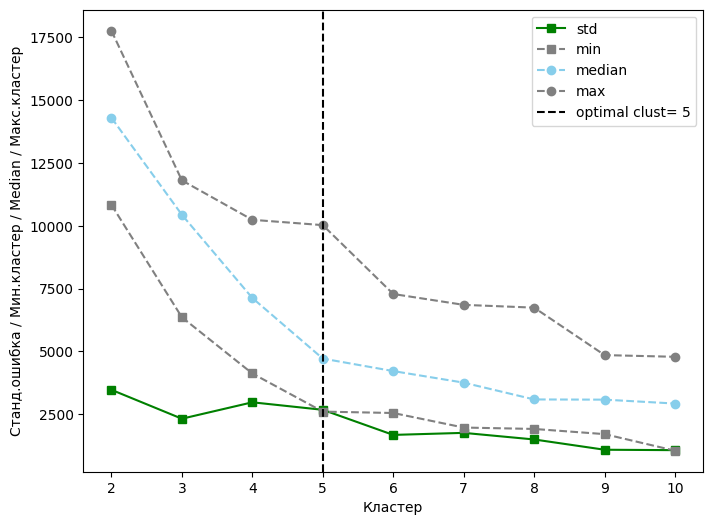

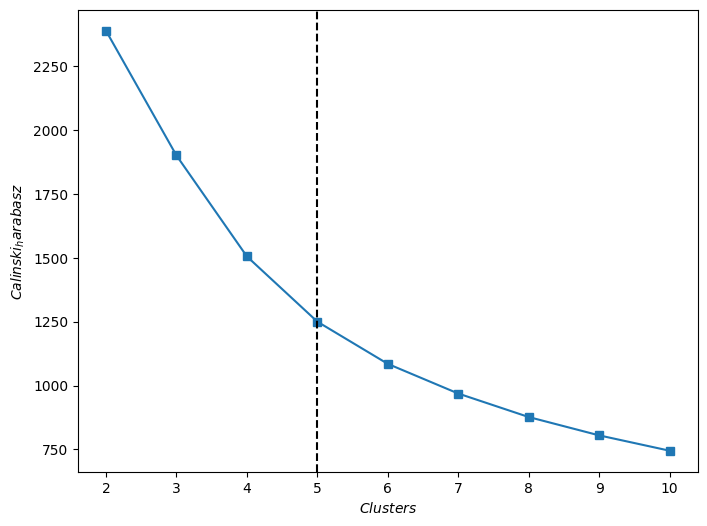

In [44]:
arr_std = []
arr_min = []
arr_median = []
arr_max = []
arr_calinski_harabasz = []
arr_silhouette = []

min_label = 2
max_label = 10

for n_clusters in range(min_label, max_label+1):
    model = KMeans(n_clusters=n_clusters, random_state=RAND)
    model.fit(cleaned_dataset)

    plot_top_features(cleaned_dataset, model.labels_, n_clusters)
    silhouette_plot(cleaned_dataset, model.labels_, metrics='cosine')
    check_fullness(cleaned_dataset, model.labels_)
    plot_size(cleaned_dataset, model.labels_)

    arr_calinski_harabasz.append(
        calinski_harabasz_score(cleaned_dataset, model.labels_))
    arr_silhouette.append(silhouette_score(
        cleaned_dataset, model.labels_, metric='cosine'))
    counts = np.unique(model.labels_, return_counts=True)
    arr_min.append(counts[1].min())
    arr_max.append(counts[1].max())
    arr_median.append(np.median(counts[1]))
    arr_std.append(np.std(counts[1]))

elbow_picture(labels_std=arr_std,
              labels_min=arr_min,
              labels_max=arr_max,
              labels_median=arr_median,
              type_optimal=arr_median,
              min_size=min_label,
              max_size=max_label)

metric_picture(arr_calinski_harabasz,
               min_size=min_label,
               max_size=max_label,
               name_metric="Calinski_harabasz")

In [64]:
model_5 = KMeans(n_clusters = 5, random_state=RAND)
model_5.fit(cleaned_dataset)

KMeans(n_clusters=5, random_state=10)

In [65]:
binary_label = cleaned_dataset.assign(cluster=model_5.labels_)
size_cluster = binary_label.groupby('cluster').count().iloc[:, 0]
data_sum = binary_label.groupby('cluster').sum()
data_sum_norm = data_sum.T / size_cluster * 100

<AxesSubplot:xlabel='cluster'>

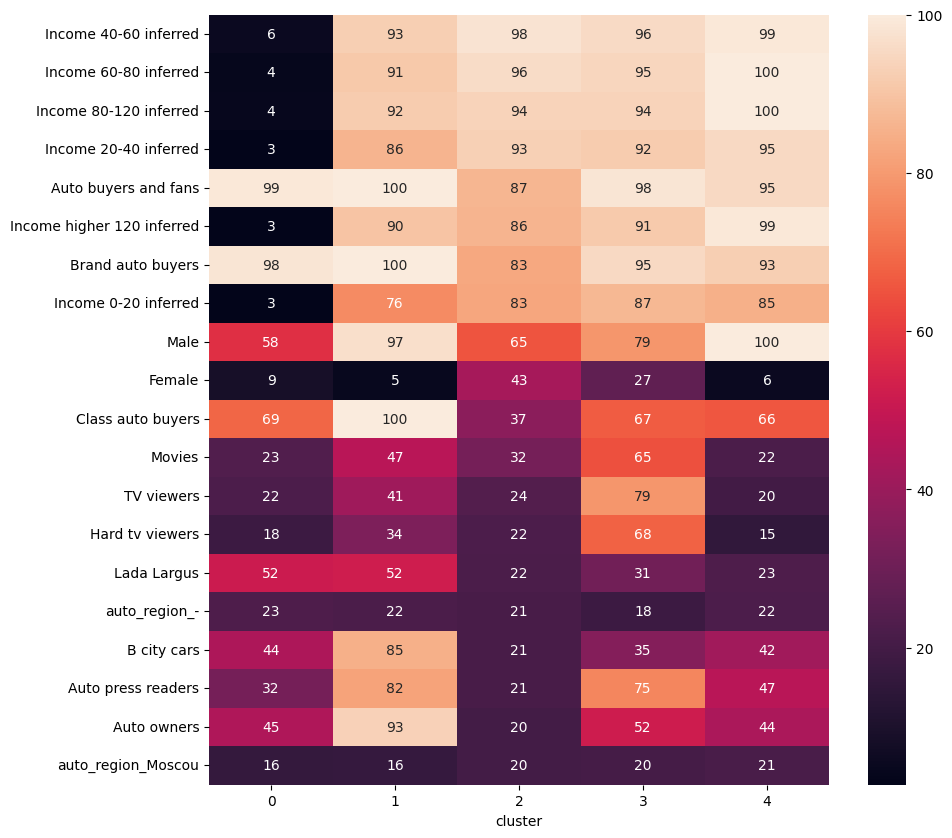

In [68]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_sum_norm.loc[:].sort_values(by=2, ascending=False)[:20], fmt='.0f', annot=True)

Несмотря на результаты метода локтя, выбор 5 кластеров по методу KMeans, на мой взгляд, ошибочно, так как сами кластеры получились плохи с точки зрения интерпретации. Непонятно, как охарактеризовать кластер 0 и кластер 2.

14) Выбор оптимального кол-ва кластеров и вывод графиков:

- Выбрать оптимальное кол-во кластеров (основывайтесь на разных метриках, в том числе и на интерпретации) и обучите алгоритм Kmeans (применять цикл не нужно) на cleaned_dataset
- Отобразите эмбеддинги для cleaned_dataset на двумерном графике, цветами обозначьте метки новых кластеров

In [51]:
model_4 = KMeans(n_clusters = 4, random_state=RAND)
model_4.fit(cleaned_dataset)

KMeans(n_clusters=4, random_state=10)

In [52]:
binary_label = cleaned_dataset.assign(cluster=model_4.labels_)
size_cluster = binary_label.groupby('cluster').count().iloc[:, 0]
data_sum = binary_label.groupby('cluster').sum()
data_sum_norm = data_sum.T / size_cluster * 100

<AxesSubplot:xlabel='cluster'>

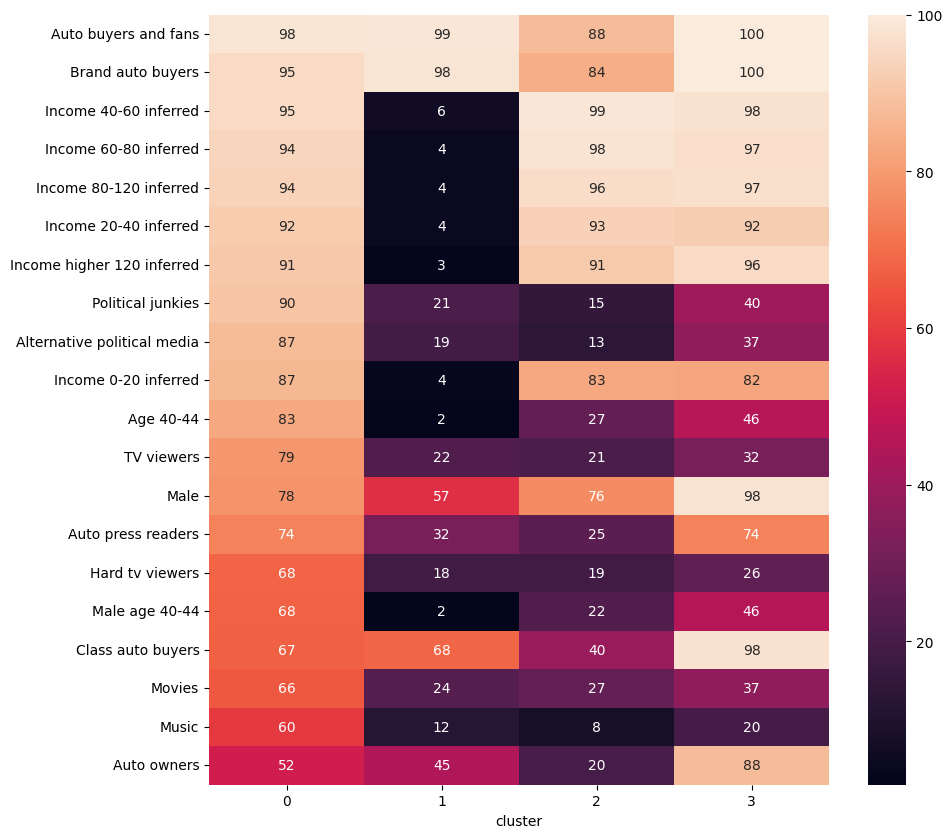

In [53]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_sum_norm.loc[:].sort_values(by=0, ascending=False)[:20], fmt='.0f', annot=True)

<AxesSubplot:>

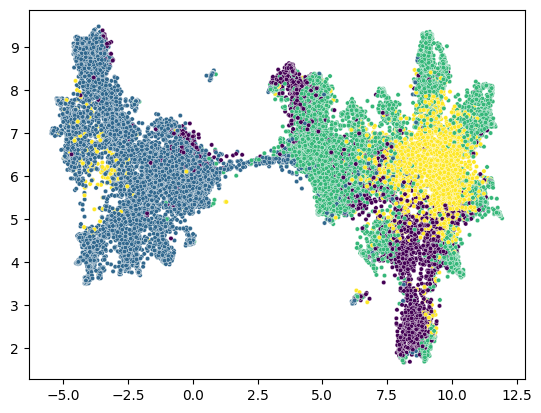

In [54]:
sns.scatterplot(x=x_embedding[:, 0],
                y=x_embedding[:, 1], s=10, c=model_4.labels_)

15) Интерпретация результатов

- Создайте новый датасет cleaned_dataset_km копию cleaned_dataset, добавьте столбец target - кластеры, полученные в задании 14
- Посчитайте кол-во объектов в каждом кластере, запишите в переменную count
- Отнормируйте кол-во объектов в каждом из признаков в кластере на общее кол-во объектов в кластере - count, запишите в переменную normalize_km
- Постройте heatmap для normalize_km heatmap и **опишите каждый кластер**

In [55]:
cleaned_dataset_km = cleaned_dataset.copy()
cleaned_dataset_km['target'] = model_4.labels_

<AxesSubplot:xlabel='target'>

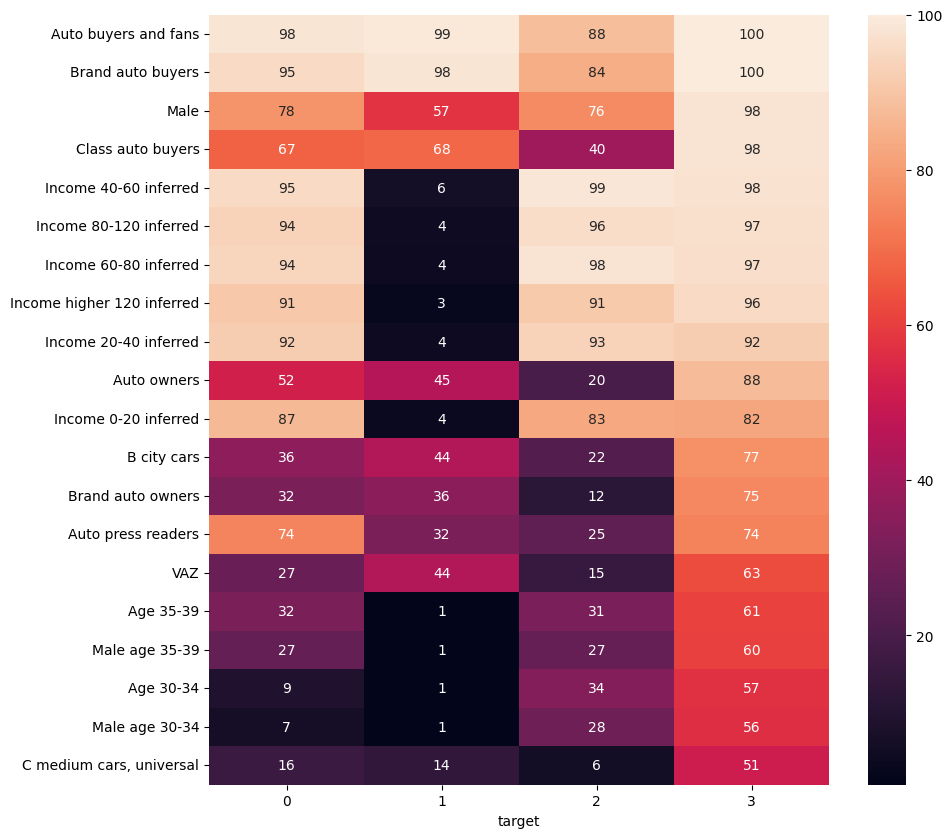

In [60]:
size_cluster = cleaned_dataset_km.groupby('target').count().iloc[:, 0]
data_sum = cleaned_dataset_km.groupby('target').sum()
data_sum_norm = data_sum.T / size_cluster * 100

plt.figure(figsize=(10, 10))
sns.heatmap(data_sum_norm.loc[:].sort_values(
    by=3, ascending=False)[:20], fmt='.0f', annot=True)

1 кластер: автолюбители с высоким доходом, интересующиеся политикой  
2 кластер: автолюбители  
3 кластер: автолюбители с высоким доходом  
4 кластер: автолюбители-мужчины с высоким доходом, владеющие авто и интересующиеся легковыми автомобилями  

16) Сравните разные подходы кластеризации, выберите тот метод, которые лучше всего разделил на кластеры с учетом интерпретации

Лучше всего задачу кластеризации выполнила спектральная кластеризация, выделив 5 кластеров с ясной интерпретацией и относительно хорошими значениями метрик качества 

# * Задание со звездочкой

Создайте функцию/ии, которые бы отображали ТОП-N признаков по таким категориям в каждом из кластеров:
    
- Общие признаки, не включая сведения о доходах (Income), пол, возраст, расположение (auto region)
- Расположение (auto region)
- Пол
- Возраст

Можете расположить данные категории в одну строку, каждая строка характеризует какой-то кластер

Пример с картинкой можно увидеть на платформе

P.S. также при помощи данного задания вы можете оценить интерпретацию и других методов кластеризации